In [10]:
### MAIN IMPORT BLOCK

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
keras.utils.set_random_seed(42)
import pandas as pd
import tensorflow as tf

In [3]:
# Definig a callable function to make some steps idempotent

def get_data():

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    
    return (x_train, y_train), (x_test, y_test)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
Label: 5


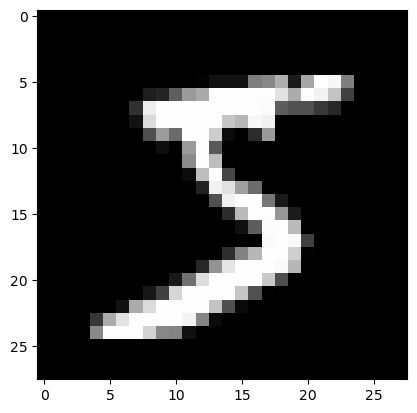

In [4]:
(x_train, y_train), (x_test, y_test) = get_data()

import matplotlib.pyplot as plt
print(f"Label: {y_train[0]}")
plt.imshow(x_train[0], cmap='gray')
plt.show()


In [5]:
# Exploring the number of classes of the target

unique_values = np.unique(y_train)
print(unique_values)

print("Number of classes: ", len(unique_values))

[0 1 2 3 4 5 6 7 8 9]
Number of classes:  10


##### Data Preparation:

Forcing numpy data type to float32.

Supposing that each pixel is represented according to a 8-bit gray scale, the possible values of grey intensity fall between 0 and 255 (2^8). So in order to normalize those values between 0 and 1 we have to divide each value by 255. This data preparation step is needed in order to get a range of values that is well suited for machine learning models as it ensures numerical stability during training and faster convergence.

CNNs are designed to work with multichannel data (RGB: Red, Green, Blue, 8-bit scale for each color) so in order to handle this adding a new "channel" dimension is necessary, so we convert the instances matrix shape from (num_samples, height, width) to (num_samples, height, width, 1), where 1 refers to a single channel of grey scale. 

Label classes are converted as array encoding categorical meaning:
Example label:  7 --> Example label converted:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

In [6]:
# make this cell idempotent
(x_train, y_train), (x_test, y_test) = get_data()

# normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# add a new axis of value 1 representing grey-scale channel (if RGB it would 3)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape, x_test.shape)

num_classes = 10

print("Example label: ", y_test[0])

# converting labels to vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Example label converted: ", y_test[0])

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1)
Example label:  7
Example label converted:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [7]:
y_test.shape

(10000, 10)

# Approach Description and Architectural Choices

#### Objective
To design a convolutional neural network (CNN) with a maximum of 7,000 trainable parameters while maximizing accuracy.


The first Architectural Draft have been designed according to the following graph:

###### input convolutional > max_pooling > (convolutional > max_pooling > batch_normalization)** > flatten > (dense)** > dense output

** the block of layers in the parenthesis set can be repetead n time according to a deterministic rule that avoids to exceed the max number of parameters

The idea of this first architectural attempt was to base the training mostly on the convolutional part rather than the final desnse layers. So according to this logic, it first attempts to create the maximum number of possible convolutional layers (without exceeding the threshold of 7K parameters) doubling the number of filters at each netx convolutional layer.

This choice is based by the fact that increasing the number of filters in subsequent convolutional layers in a CNN is a common practice for the following reasons:

- Progressive Feature Extraction and Hierarchical Learning
The first convolutional layers capture basic, low-level features like edges and textures. Deeper layers with more filters focus on more complex, high-level features like shapes or objects.
Increasing the number of filters allows the network to represent and learn a richer variety of features as the spatial dimensions decrease (due to max_pooling layer always subsequently to the conv layer).

- Efficient Parameter Utilization
Early layers have larger spatial dimensions and fewer filters, while deeper layers have smaller spatial dimensions but more filters. This trade-off keeps the total parameter count in check while allowing the model to extract detailed features.

- Empirical Performance
In practice, doubling the filters in deeper layers often results in better performance across various tasks. This has been validated by many architectures like VGG, ResNet, and DenseNet.

- Dealing with Information Bottleneck
More filters help mitigate the risk of losing crucial information in deeper layers, especially as spatial resolution decreases.



###### 1. Input Layer
In order to ensure compatibility with various datasets and to generalize the problem, the model accepts dynamically defined input dimensions, e.g., (height, width, channels).


##### 2. Convolutional Layers

**First Layer (Input Convolutiona Layer):**

*Filters:* 16 filters (kernel size 3x3).
Each filter is a small matrix MxN that slides over the input data.

Each filter should learn a specific pattern/feature from the data (edges, corners, textures, ...). So for instace, 16 filters lead this layer to learn 16 patterns.

The complexity of the model that arises from this layer can ba calculated as follow: 
Each filter has MxNxC weights + 1 bias, where C represents the channel dimension, equals to 1 in our case (grey scale).
The number of parameters of the input convolutional layer is calculated as: 
**(filter_dimension x filter_dimension x n_channels + 1) x filters**
Where 1 represent the bias calculated for each filter.


I choose as base number of filter 16 and 3x3 as base level of filter size.
16 seems to be a suitable choice for not complex images like digits where likely the number of pattern to learn should not be huge.
A small number of filters ensures low initial parameter usage:
For instance, in the fisrt convolutional layer we have (3×3×1+1)×16 filters = 160 parameters.
In this way it reduces the risk of overfitting on small datasets like MNIST (60000 training instances).

*Activation: ReLU*.
ReLU applies a simple operation f(x) = max(0, x) that is computationally efficient.
It provides non-linearity allowing the network to learn complex patterns and hierarchies in the data, which improves accuracy.
ReLU outputs zero for all negative inputs, which introduces sparsity in the activations. This sparsity reduces the effective number of computations required and works well with Shared Weights property of CNN (it applies the same weights to different regions of the input image): sparsity  amplifies the filter's ability to focus on relevant spatial features without adding complexity.
ReLU avoids saturation for positive inputs, where gradients would become very small. This property ensures faster convergence during training.

**Dynamic Layers:**

As described in architectural choice section, adding depth helps to extract hierarchical features (e.g., edges, textures).

So deeper convolutional layers are added iteratively according to the following strategy:
Each new layer doubles the number of filters from 16 to max 64, in order to control the growth of parameters number and to limit the number of pattern needed to learn avoiding model's complexity to explode.

The number of parameters computed for the deeper convolutiona layers follows this formula:
**(filter_dimension x filter_dimension x filters/2) x filters + filters** 
Where filters is divided by 2 in order to compute the number of channels output from the previous layer (that we have doubled before according to the logic described above)


##### 3. Pooling Layers
Pooling Method: MaxPooling (2x2), retain the max value of each NxN not overlapped submatrix of the input.
Reduces spatial dimensions of the features maps while retaining essential information, this leads to: 
Controlling the growth of parameters in subsequent layers.
Mitigates overfitting by reducing the model's capacity to memorize the input.
Improving computational efficiency.
Translation Invariance: Pooling helps to summarize regions of the input, making the learning robust to slight spacial translation. Applying MaxPooling immediately after a convolution layer helps in distilling features extracted by kernes, retaining the most dominant features (via max value) and discarding less significant details.

##### 4. Batch Normalization
Added after each convolutional block to stabilize training and improve generalization. Helps mitigate internal covariate shift.
After MaxPooling, the feature maps are downsampled but may still have wide variations in their values (e.g., due to different activations or pooling results). BatchNorm ensures that the activations have Zero mean and unit variance (normalized distribution). This stabilization improves the convergence of the network during training. This is particular important considering I want to try to keep fixed hyperparameters like epochs number in order to focus on CNN architecture.
So enabling higher learning rates should accelerates convergence within the 15-epoch limit.

A Batch Normalization layer has to learn a number of parameter for each channel the layer has in order to normalize the output.
According to tensorflow documentation (https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) BatchNormalization layer learns 2 params for each channel: gamma for scaling and beta for offset (to shift the normalized values). Additionally, it maintains 2 non-trainable params for each channel (moving mean and moving variance).

So the formula to count the number of params within this layer is:
**params = 4 x C**


##### 5. Flatten Layer
Converts the multi-dimensional feature maps into a single vector in order to connect Convolutional Layers (feature extractions task) to dense (fully-connected) layers needed for classification task.
Flatten Layer works reordering and reshaping the tensor without altering the data. It simply arranges the values from the feature maps into a single row combining local features output from previous layers as global insight about the image to classify.

##### 6. Dense Layers
Dynamic Dense Layer:

Just before the final output layer this architecture try to insert a Dense Layer, this is achieved according to a simple determinist formula that should establish if the paramaters of the Dense Layer does not exceed the maximum value of parameters. According to this logic the formula assign a suitable number of dense units to this full-connected layer.

The influece of the Dense Layer to the whole number of parameters of the CNN is calculated as follows:
**flattened_size x dense_units + dense_units = (flattened_size + 1) x dense_units**
Each dense unit gets data from |flattened_size| + 1 bias, where flattened_size represents the output dimension coming from the Flatten Layer and the final + dense_units represents the number of biases associated to each neuron's output.

The goal of the Dense Layer is to aggregate the spatial features extracted by the convolutional layers (that are actually fragmented across multiple channels), providing the model the capacity to learn and prioritize complex, non-linear combinations of the spatial features and relationships.

Another important point related to the interposition of this layer is the dimensionality reduction that implies the managing of the number of weight of the next layer. For example: 
In a Convolutional Neural Network (CNN), the flattening layer takes the multi-dimensional feature map (height, width, depth) produced by the final convolutional/pooling layers and reshapes it into a 1D feature vector. So a feature of maps of 4 × 4 × 64 becames a vector of 1024 elements. This flattened vector contains all the spatial and hierarchical information learned by the previous layers. If we directly connect this flattened vector  to the output layer of 10 classes, the connection would require 
10240 weights plus 10 biases (see the formula in the next paragraph).

The fully-connected layers reduces the dimensionality according to the number of dense units of the layer. The logic defined try to assign the max number of dense unit starting from 128 and halving it until a suitable number of units is found. 

**Output Layer:**

Activation: Softmax.
The role of this layer is of course transform the output from the previous layer to a normalized class probabilities, suitable for multi-class classification.
The number of weights needed by this layer has been calculated as:
**(dense_units + 1) * num_classes**



#### Hyperparameter Choices

For this assignement i focus mainly on the CNN's architecture part so Hyperparams choices have been kept simple.

1. Learning Rate
Default Adam optimizer with adaptive learning rates.
Combines the benefits of RMSProp and momentum, adapting learning rates for faster convergence within 15 epochs.

2. Batch Size
Set to 128, balancing computational efficiency and gradient stability.
Hopefully small enough to allow diverse mini-batches but large enough for GPU acceleration.

3. Epochs
I started keeping the epochs number fixed at 15.

4. Parameter Limitation
Up to 7,000 trainable parameters enforced dynamically as requested by the assignement description.
Params number = kernel params + bias + dense params

**Some considerations about limiting the overall model's weights in a dynamic way:**

Encourages architectural efficiency, preventing overfitting on small datasets like MNIST.
Filters and layer depth adjusted based on input shape and remaining parameter budget.
Dataset-Agnostic:Architecture generalizes to different datasets, provided they have a defined number of classes and input dimensions.
Maximizing Features extraction: Convolutional layers extract as many features as possible within the parameter limit.
Reduced Dense Complexity: Dense layers consume the largest number of parameters so i focus on a model based on convolutional features over dense connections.
Batch Normalization:
Stabilizes the training process, reducing sensitivity to initialization and learning rates.


Example of parameters number calculation for MNIST:

Input shape: 28 × 28 × 1
Output classes: 10. 
First Conv Layer: ( 3 × 3 × 1 + 1 ) × 16 = 160 
Second Conv Layer: ( 3 × 3 × 16 + 1 ) × 32 = 4640 
Dense Layer (128 units): 128 × 10 = 1280 

Total: 160 + 4640 + 1280 = 6080

Trade-offs Depth vs. Width:
 - Prioritized depth to extract hierarchical features.
 - Limited the number of dense units to manage parameter growth.
 - Simplified dense layers while retaining sufficient expressivity in convolutional layers.

###### Validation and Metrics

Validation Split: 10% of training data used for validation.
Metric: Accuracy.


##### The method: build_cnn()

The custom function build_cnn create a level of abstraction over what described above allowing to apply the logic for the creation of the CNN respect of the max number of parameters. In order to make the CNN definition more dynamic the method takes as input some hyperparams like:
 - num_classes
 - max_params (default=7000)
 - filter_dimension (default=3): (the dimensions of each kernel used in the convolutional layers)
 - filters (default=16): the base number of filters for each layer
 - pooling_dimension (default=4): the dimansion n of the n x n matrix used during max pooling operation
 - dense_units: the number of dense units that the function tries to apply as first attempt to the dense layer (as described above)
 - doubling_filters (default=True): If False, it deactivates the doubling of the filters number at each next convolutional layer (as described above)
 
 
The method build_cnn returns the model and a subset of hyperparams that will be used later to track the effect of each hyperparams on the model behaviour during testing phase.
 

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Function to build a CNN dynamically based on dataset dimensions with a fixed level of max parameters
### During the building process two main variables counter are considered:
###### current_shape: the dimension of the input map
###### params_count: the number of parameters reached at that moment of the execution
def build_cnn(input_shape, num_classes, max_params=7000, filter_dimension = 3, filters = 16, pooling_dimension = 4,
              dense_units = 128, doubling_filters=True):
    
    print("Building Model with:")
    print("input_shape: ", input_shape)
    print("num_classes: ", num_classes)
    print("max_params: ", max_params)
    
    n_filters = filters
    
    # init the Sequential and the counters
    model = models.Sequential()
    params_count = 0
    current_shape = input_shape
    print("current_shape: ", current_shape)

    # Add the first convolutional layer
    model.add(layers.Conv2D(filters, (filter_dimension, filter_dimension), activation='relu', input_shape=input_shape))
    params_count += (filter_dimension * filter_dimension * input_shape[-1] + 1) * filters  
    current_shape = (current_shape[0] - (filter_dimension-1), current_shape[1] - (filter_dimension-1), filters)
    print("current_shape: ", current_shape)
    
    print("Params count of the first conv input layer: ", params_count)

    # Add a pooling layer
    model.add(layers.MaxPooling2D((pooling_dimension, pooling_dimension)))
    current_shape = (current_shape[0] // pooling_dimension, current_shape[1] // pooling_dimension, current_shape[2])
    print("current_shape: ", current_shape)

    # Add more layers dynamically, keeping parameter count in check
    conv_layers = 1
    
    # looping to add new conv layers in the max_params cap isn't reached
    while params_count < max_params:
        
        # filters actually represent also the number of channel output from the conv layer
        if doubling_filters:
            filters *= 2
            if filters > 64:  # doubling filters but avoid too many filters to limit params
                filters = 64
        
        # CONDITIONAL PART
        # filter shape x input channels x output channels x output biases
        conv_params = (filter_dimension * filter_dimension * filters/2) * filters + 1*filters
        batch_normalization_params = 4 * filters
        
        print("conv_params: ", conv_params)
        print("batch_normalization_params: ", batch_normalization_params)
        
        # Update parameter count
        delta_params_count = (conv_params + batch_normalization_params)
        print("delta_params_count: ", delta_params_count)
        
        # check if is it possible to add a new convolutional layer
        if (delta_params_count + params_count < max_params):
            conv_layers+=1
            print("Adding layer: ", conv_layers)
            params_count += delta_params_count
            print("NEW TOTAL PARAMS: ", params_count)
            
            model.add(layers.Conv2D(filters, (filter_dimension, filter_dimension), activation='relu'))
            current_shape = (current_shape[0] - (filter_dimension-1), current_shape[1] - (filter_dimension-1), filters)
            print("current_shape: ", current_shape)
            
            model.add(layers.MaxPooling2D((pooling_dimension, pooling_dimension)))
            current_shape = (current_shape[0] // pooling_dimension, current_shape[1] // pooling_dimension, current_shape[2])
            print("current_shape: ", current_shape)
            
            model.add(layers.BatchNormalization())
        else:
            break
        
        
    print("Number of conv_layers: ", conv_layers)
    print("Number of params related to conv layers: ", params_count)
    
    
    # Calculate the flattened size
    flattened_size = np.prod(current_shape)
    print("Flattened size: ", flattened_size)
    
    # check if the overall number of parameters (considering also the default output layer) allow a further dense layer
    while flattened_size * dense_units + dense_units + num_classes*dense_units + num_classes > max_params - params_count:
        dense_units = dense_units / 2
    
    print("dense_units: ", dense_units)
    # Flatten and add a dense layer for classification
    model.add(layers.Flatten())
    
    n_dense_layers = 0
    
    # An arbitrary condition to prevent too much information lost
    if dense_units > num_classes:
        model.add(layers.Dense(dense_units, activation='relu'))
        params_count += (flattened_size * dense_units + dense_units)
        n_dense_layers+=1
        print("NEW TOTAL PARAMS: ", params_count)

    # Add the output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    params_count += (dense_units + 1) * num_classes
    n_dense_layers+=1

    print(f"Model created with {params_count} parameters.")
    print("*"*50)
    return model, params_count, n_filters, conv_layers, n_dense_layers, dense_units, filter_dimension, pooling_dimension 


In [77]:
input_shape = x_train.shape[1:]

# Build and compile the CNN
model = build_cnn(input_shape=input_shape, num_classes=num_classes)
model.summary()

Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (13, 13, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (11, 11, 32)
current_shape:  (2, 2, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  128
dense_units:  8.0
NEW TOTAL PARAMS:  5960.0
Model created with 6050.0 parameters.
**************************************************
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 m

In [75]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")


Epoch 1/15
422/422 [==============================] - 9s 19ms/step - loss: 0.5960 - accuracy: 0.8176 - val_loss: 0.2365 - val_accuracy: 0.9515
Epoch 2/15
422/422 [==============================] - 8s 19ms/step - loss: 0.1439 - accuracy: 0.9583 - val_loss: 0.1149 - val_accuracy: 0.9657
Epoch 3/15
422/422 [==============================] - 8s 19ms/step - loss: 0.1041 - accuracy: 0.9689 - val_loss: 0.0893 - val_accuracy: 0.9722
Epoch 4/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0870 - accuracy: 0.9727 - val_loss: 0.1102 - val_accuracy: 0.9648
Epoch 5/15
422/422 [==============================] - 7s 17ms/step - loss: 0.0751 - accuracy: 0.9761 - val_loss: 0.0841 - val_accuracy: 0.9755
Epoch 6/15
422/422 [==============================] - 10s 25ms/step - loss: 0.0670 - accuracy: 0.9787 - val_loss: 0.0817 - val_accuracy: 0.9755
Epoch 7/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0613 - accuracy: 0.9807 - val_loss: 0.0703 - val_accuracy: 0.976

## Experiments Description

In the following experiments the elements below have been studied: 
"n_params", "n_filters", "n_conv_layers", "dense_units", "n_dense_layers", "filter_dimension", "test_accuracy"

In particular i have studied the effect of trying differnt values of n_filters, filter_dimension and dense_units over the other elements.

In this sequence of experiment, it's important also to note that some of those elements are independent, 
for example, the number of filters and the filter dimension, inderectly affect the number of convolutional layers and the number of dense units
cause all these factors are related to the total number of parameters of the CNN Architecture.

For each iteration of the experiments:
 - History of traininig and validation phases is plotted
 - Data about the above mentioned factors are memorized in a pandas dataframe in oder to later represent them in a scatter plot (to undestand the relationships interfactors) and in a line plot (to highlight the relationship between factors and test accuracy).
 

In [8]:
# borrowed function to easily plot training and validation accuracy
def plot_performance(history):
  fig, ax = plt.subplots(1,2)
  fig.tight_layout()
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label='Training Loss')
  ax[0].plot(val_loss, label='Validation Loss')
  ax[0].legend()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Accuracy')
  ax[1].plot(train_acc, label='Training Accuracy')
  ax[1].plot(val_acc, label='Validation Accuracy')
  ax[1].legend()
  plt.show()

#plot_performance(history)

## Iterating over the Number of Filters

number of filters:  4
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 4)
Params count of the first conv input layer:  40
current_shape:  (6, 6, 4)
conv_params:  296.0
batch_normalization_params:  32
delta_params_count:  328.0
Adding layer:  2
NEW TOTAL PARAMS:  368.0
current_shape:  (4, 4, 8)
current_shape:  (1, 1, 8)
conv_params:  1168.0
batch_normalization_params:  64
delta_params_count:  1232.0
Adding layer:  3
NEW TOTAL PARAMS:  1600.0
Failed creation of CNN with 4 filters
One of the dimensions in the output is <= 0 due to downsampling in conv2d_114. Consider increasing the input size. Received input shape [None, 1, 1, 8] which would produce output shape with a zero or negative value in a dimension.
number of filters:  8
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 8)
Params count of the first conv input lay

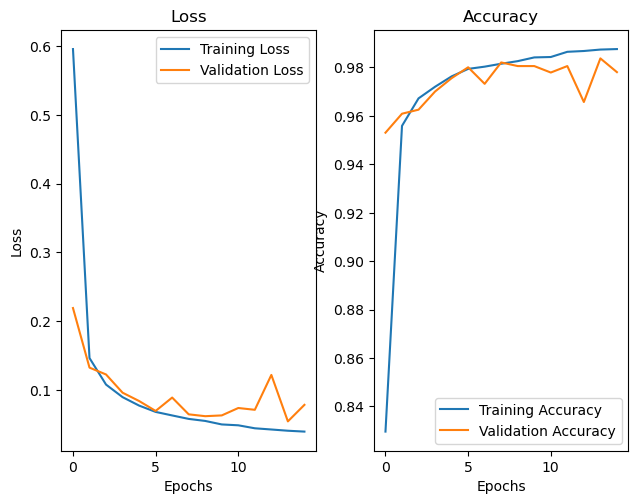

number of filters:  16
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  32.0
NEW TOTAL PARAMS:  5984.0
Model created with 6314.0 parameters.
**************************************************
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 26, 26, 16)        160       
                                                 

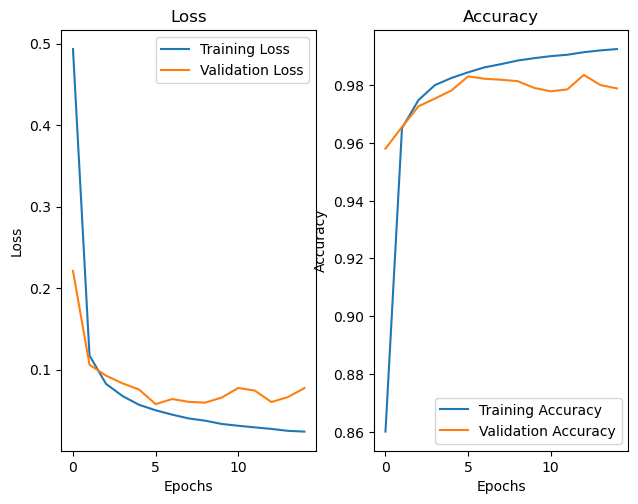

number of filters:  20
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 20)
Params count of the first conv input layer:  200
current_shape:  (6, 6, 20)
conv_params:  7240.0
batch_normalization_params:  160
delta_params_count:  7400.0
Number of conv_layers:  1
Number of params related to conv layers:  200
Flattened size:  720
dense_units:  8.0
NEW TOTAL PARAMS:  5968.0
Model created with 6058.0 parameters.
**************************************************
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 26, 26, 20)        200       
                                                                 
 max_pooling2d_108 (MaxPool  (None, 6, 6, 20)          0         
 ing2D)                                                          
                                   

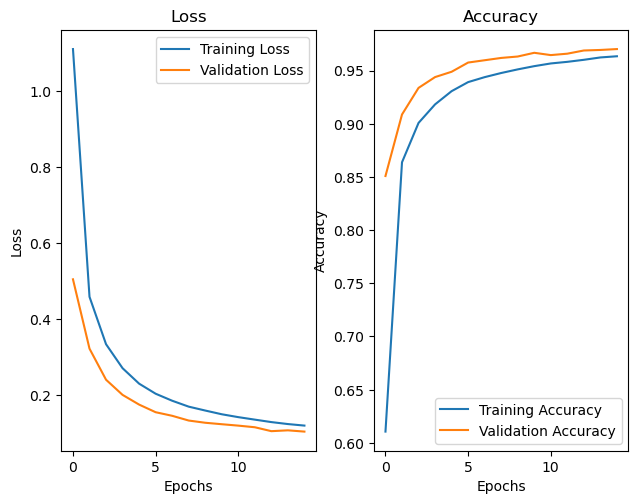

number of filters:  24
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 24)
Params count of the first conv input layer:  240
current_shape:  (6, 6, 24)
conv_params:  10416.0
batch_normalization_params:  192
delta_params_count:  10608.0
Number of conv_layers:  1
Number of params related to conv layers:  240
Flattened size:  864
dense_units:  4.0
NEW TOTAL PARAMS:  3700.0
Model created with 3750.0 parameters.
**************************************************
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 26, 26, 24)        240       
                                                                 
 max_pooling2d_109 (MaxPool  (None, 6, 6, 24)          0         
 ing2D)                                                          
                                 

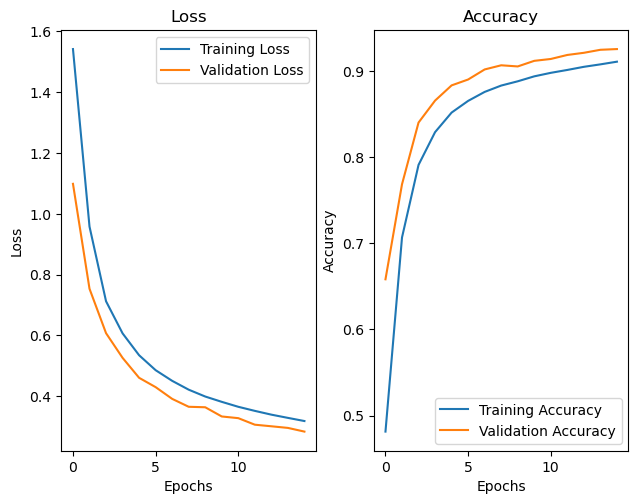

number of filters:  28
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 28)
Params count of the first conv input layer:  280
current_shape:  (6, 6, 28)
conv_params:  14168.0
batch_normalization_params:  224
delta_params_count:  14392.0
Number of conv_layers:  1
Number of params related to conv layers:  280
Flattened size:  1008
dense_units:  4.0
NEW TOTAL PARAMS:  4316.0
Model created with 4366.0 parameters.
**************************************************
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d_110 (MaxPool  (None, 6, 6, 28)          0         
 ing2D)                                                          
                                

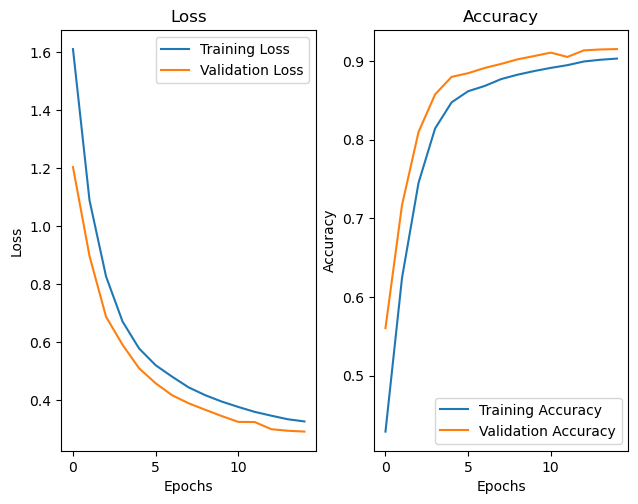

number of filters:  32
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 32)
Params count of the first conv input layer:  320
current_shape:  (6, 6, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  1
Number of params related to conv layers:  320
Flattened size:  1152
dense_units:  4.0
NEW TOTAL PARAMS:  4932.0
Model created with 4982.0 parameters.
**************************************************
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_111 (MaxPool  (None, 6, 6, 32)          0         
 ing2D)                                                          
                                

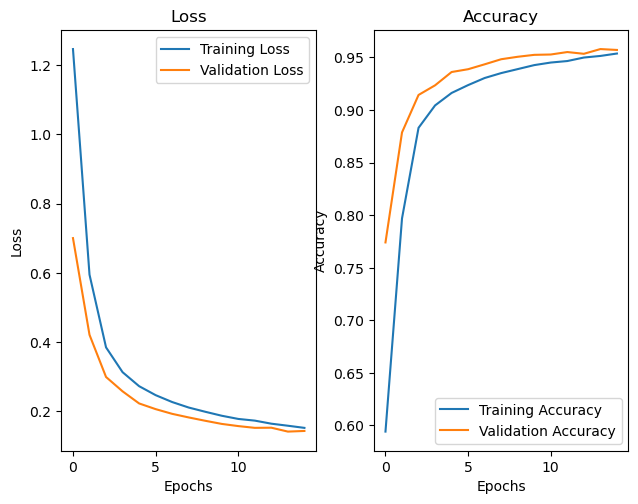

In [96]:

# defining dictionary to save interations data
filter_results = {
    
    "n_params": [],
    "n_filters": [],
    "n_conv_layers": [],
    "n_dense_layers": [],
    "dense_units": [],
    "filter_dimension": [],
    "max_pooling_dimension": [],
    "test_accuracy": []
    
}

for filters in range(4, 36, 4):
    print("number of filters: ", filters)
    # Get input shape
    input_shape = x_train.shape[1:]
    
    try:
        # Build and compile the CNN
        model, n_params, n_filters, n_conv_layers,\
            n_dense_layers, dense_units, filter_dimension,\
            max_pooling_dimension = build_cnn(input_shape=input_shape, num_classes=num_classes, filters=filters)
        
        model.summary()

        model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

        # Train the model
        history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

        # Evaluate the model
        test_loss, test_acc = model.evaluate(x_test, y_test)
        print(f"Test Accuracy: {test_acc}")

        plot_performance(history)
        
        filter_results["n_params"].append(n_params)
        filter_results["n_filters"].append(n_filters)
        filter_results["n_conv_layers"].append(n_conv_layers)
        filter_results["n_dense_layers"].append(n_dense_layers)
        filter_results["dense_units"].append(dense_units)
        filter_results["filter_dimension"].append(filter_dimension)
        filter_results["max_pooling_dimension"].append(max_pooling_dimension)
        filter_results["test_accuracy"].append(test_acc)
        
    except Exception as e:
        print(f"Failed creation of CNN with {filters} filters")
        print(str(e))
        


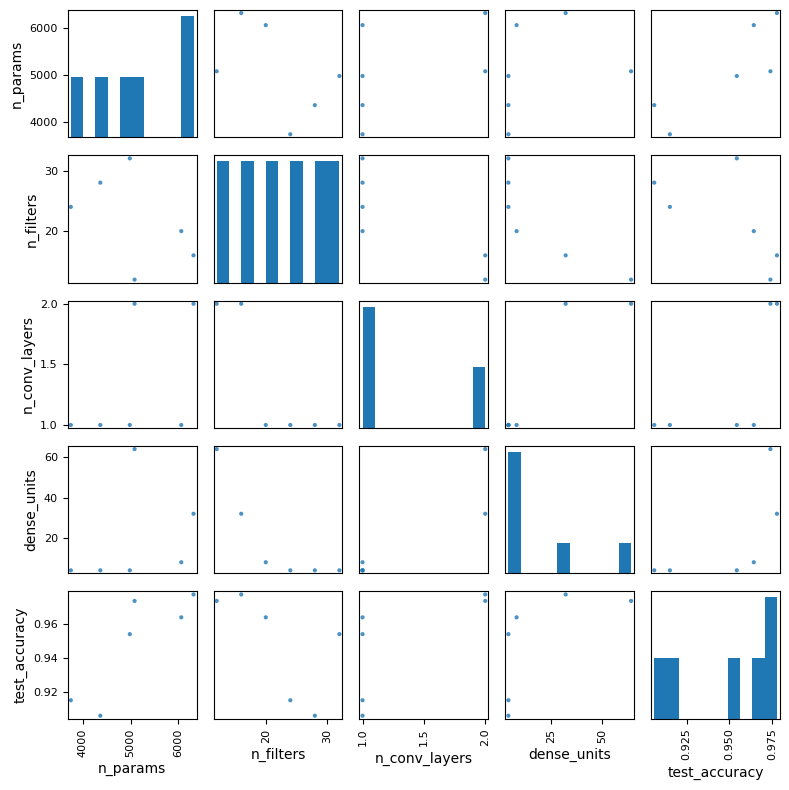

In [100]:
from pandas.plotting import scatter_matrix

filter_df = pd.DataFrame(filter_results)
scatter_matrix(filter_df[["n_params", "n_filters", "n_conv_layers", 
                          "dense_units", "test_accuracy"]], figsize=(8, 8), alpha=0.8)

# Show the plot
plt.tight_layout()
plt.show()

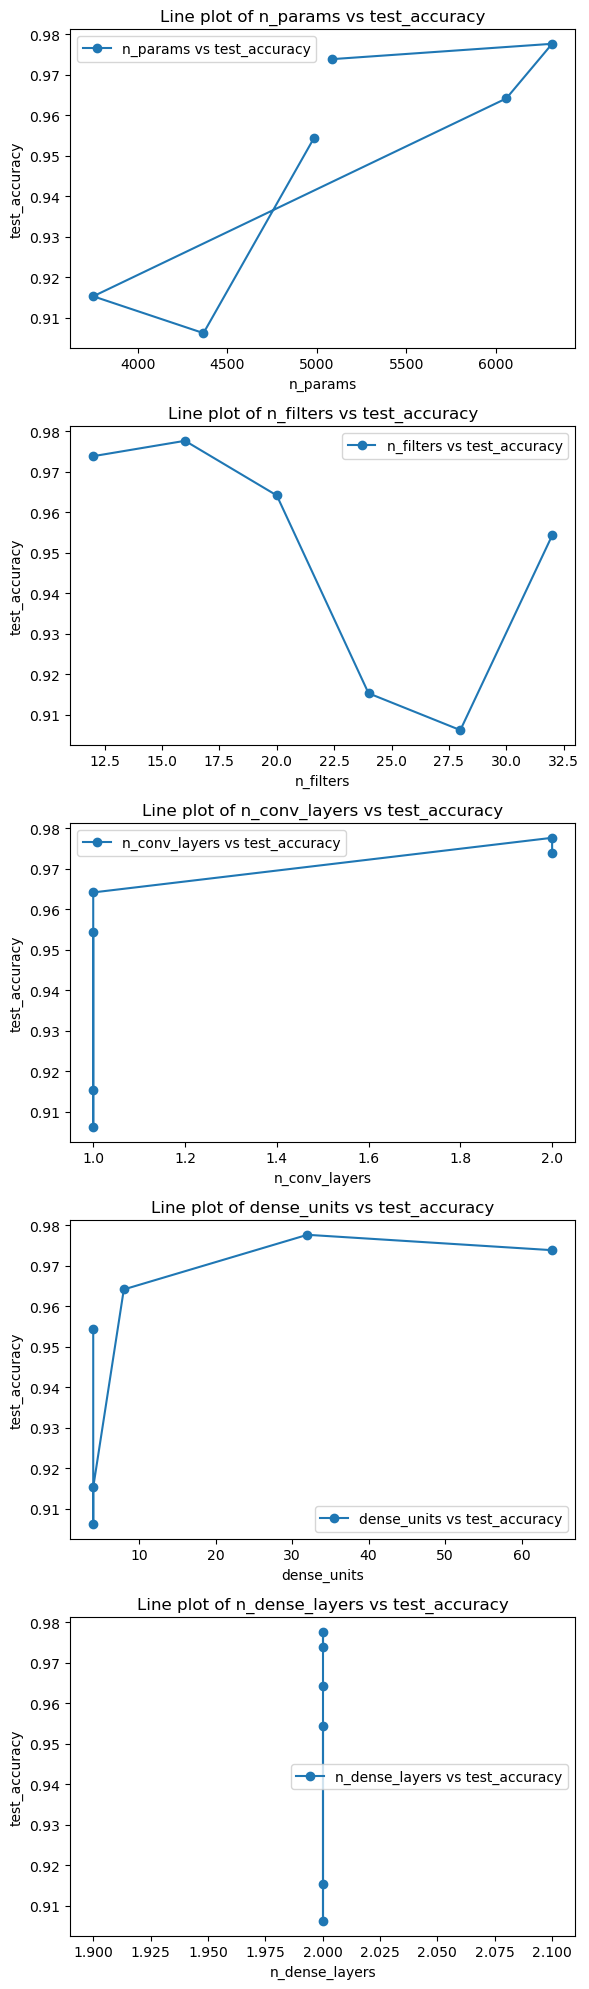

In [109]:
### Analyzing influence on accuracy

y_col = "test_accuracy"

ind_var_list = ["n_params", "n_filters", "n_conv_layers", "dense_units", "n_dense_layers"]

fig, axes = plt.subplots(len(ind_var_list), figsize=(6, 4 * (len(ind_var_list))))

for i, x_col in enumerate(ind_var_list):
    if x_col != y_col:
        ax = axes[i]
        ax.plot(filter_df[x_col], filter_df[y_col], marker="o", label=f"{x_col} vs {y_col}")
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(f"Line plot of {x_col} vs {y_col}")
        ax.legend()

plt.tight_layout()
plt.show()

## Iterating over the Filters Dimension

filter_dimension:  2
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  80
current_shape:  (6, 6, 16)
conv_params:  2080.0
batch_normalization_params:  128
delta_params_count:  2208.0
Adding layer:  2
NEW TOTAL PARAMS:  2288.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  8256.0
batch_normalization_params:  256
delta_params_count:  8512.0
Number of conv_layers:  2
Number of params related to conv layers:  2288.0
Flattened size:  32
dense_units:  64.0
NEW TOTAL PARAMS:  4400.0
Model created with 5050.0 parameters.
**************************************************
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 27, 27, 16)        80        
                                                      

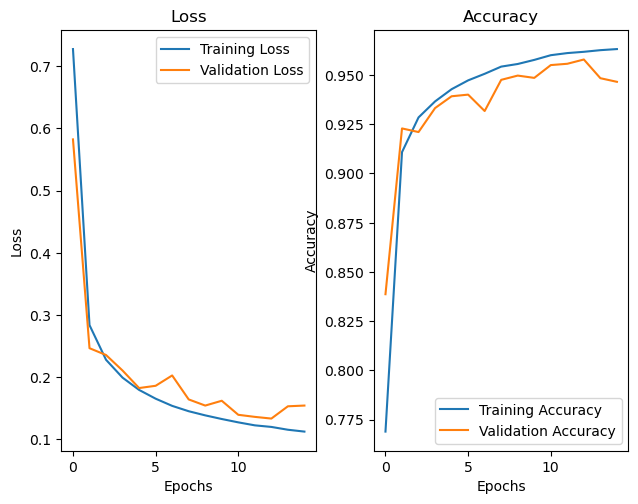

filter_dimension:  3
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  32.0
NEW TOTAL PARAMS:  5984.0
Model created with 6314.0 parameters.
**************************************************
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 26, 26, 16)        160       
                                                   

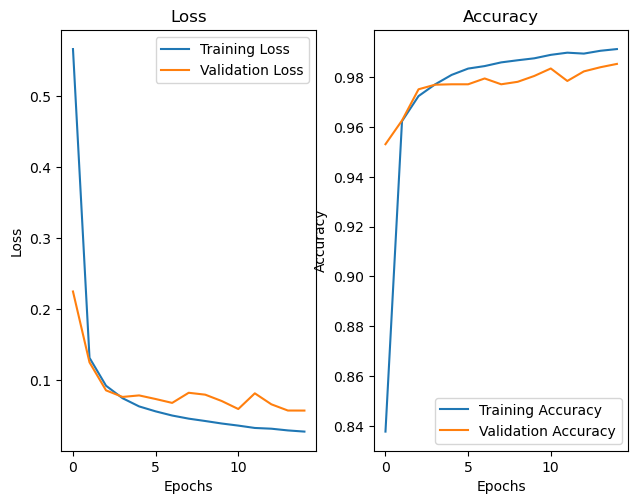

filter_dimension:  4
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  272
current_shape:  (6, 6, 16)
conv_params:  8224.0
batch_normalization_params:  128
delta_params_count:  8352.0
Number of conv_layers:  1
Number of params related to conv layers:  272
Flattened size:  576
dense_units:  8.0
NEW TOTAL PARAMS:  4888.0
Model created with 4978.0 parameters.
**************************************************
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_118 (MaxPool  (None, 6, 6, 16)          0         
 ing2D)                                                          
                                     

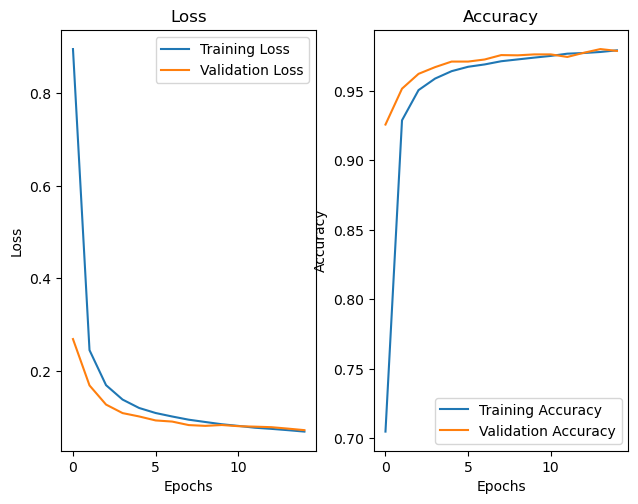

filter_dimension:  5
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  416
current_shape:  (6, 6, 16)
conv_params:  12832.0
batch_normalization_params:  128
delta_params_count:  12960.0
Number of conv_layers:  1
Number of params related to conv layers:  416
Flattened size:  576
dense_units:  8.0
NEW TOTAL PARAMS:  5032.0
Model created with 5122.0 parameters.
**************************************************
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_133 (Conv2D)         (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d_119 (MaxPool  (None, 6, 6, 16)          0         
 ing2D)                                                          
                                   

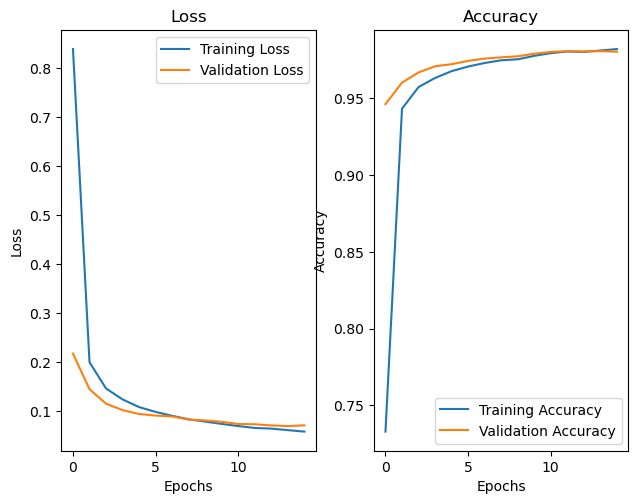

filter_dimension:  6
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  592
current_shape:  (6, 6, 16)
conv_params:  18464.0
batch_normalization_params:  128
delta_params_count:  18592.0
Number of conv_layers:  1
Number of params related to conv layers:  592
Flattened size:  576
dense_units:  8.0
NEW TOTAL PARAMS:  5208.0
Model created with 5298.0 parameters.
**************************************************
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_134 (Conv2D)         (None, 23, 23, 16)        592       
                                                                 
 max_pooling2d_120 (MaxPool  (None, 5, 5, 16)          0         
 ing2D)                                                          
                                   

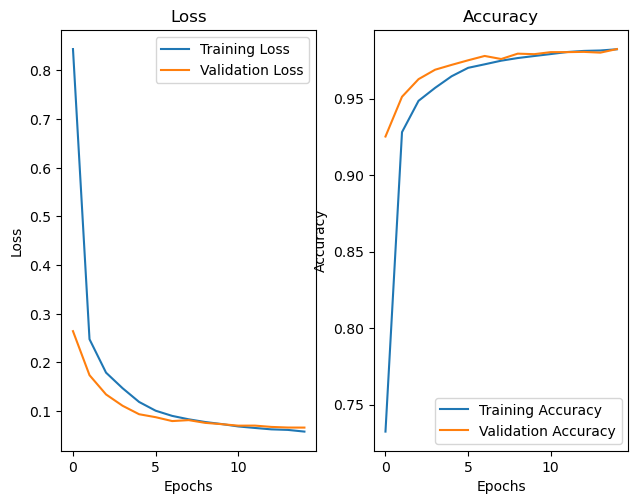

filter_dimension:  7
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  800
current_shape:  (6, 6, 16)
conv_params:  25120.0
batch_normalization_params:  128
delta_params_count:  25248.0
Number of conv_layers:  1
Number of params related to conv layers:  800
Flattened size:  576
dense_units:  8.0
NEW TOTAL PARAMS:  5416.0
Model created with 5506.0 parameters.
**************************************************
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 22, 22, 16)        800       
                                                                 
 max_pooling2d_121 (MaxPool  (None, 5, 5, 16)          0         
 ing2D)                                                          
                                   

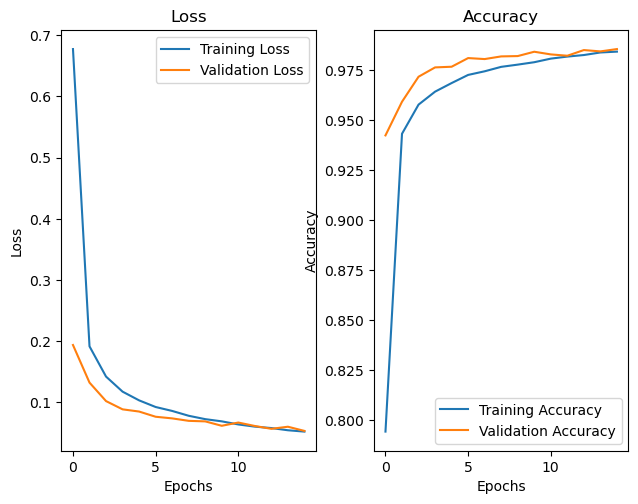

filter_dimension:  8
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  1040
current_shape:  (6, 6, 16)
conv_params:  32800.0
batch_normalization_params:  128
delta_params_count:  32928.0
Number of conv_layers:  1
Number of params related to conv layers:  1040
Flattened size:  576
dense_units:  8.0
NEW TOTAL PARAMS:  5656.0
Model created with 5746.0 parameters.
**************************************************
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_136 (Conv2D)         (None, 21, 21, 16)        1040      
                                                                 
 max_pooling2d_122 (MaxPool  (None, 5, 5, 16)          0         
 ing2D)                                                          
                                 

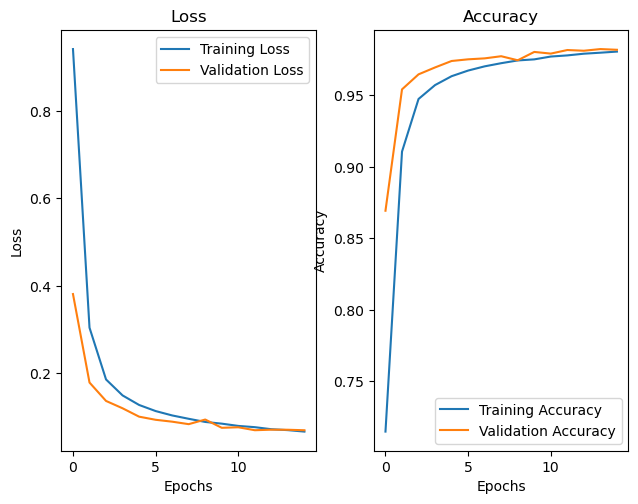

filter_dimension:  9
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  1312
current_shape:  (6, 6, 16)
conv_params:  41504.0
batch_normalization_params:  128
delta_params_count:  41632.0
Number of conv_layers:  1
Number of params related to conv layers:  1312
Flattened size:  576
dense_units:  8.0
NEW TOTAL PARAMS:  5928.0
Model created with 6018.0 parameters.
**************************************************
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_137 (Conv2D)         (None, 20, 20, 16)        1312      
                                                                 
 max_pooling2d_123 (MaxPool  (None, 5, 5, 16)          0         
 ing2D)                                                          
                                 

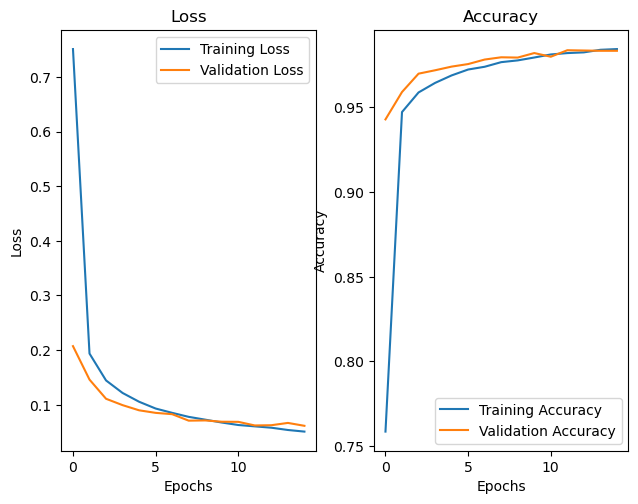

In [105]:
filter_dimension_results = {
    
    "n_params": [],
    "n_filters": [],
    "n_conv_layers": [],
    "n_dense_layers": [],
    "dense_units": [],
    "filter_dimension": [],
    "max_pooling_dimension": [],
    "test_accuracy": []
    
}

for filter_dimension in range(2, 10, 1):
    print("filter_dimension: ", filter_dimension)
    # Get input shape
    input_shape = x_train.shape[1:]
    
    try:
        # Build and compile the CNN
        model, n_params, n_filters, n_conv_layers,\
            n_dense_layers, dense_units, filter_dimension,\
            max_pooling_dimension = build_cnn(input_shape=input_shape, num_classes=num_classes, filter_dimension=filter_dimension)
        
        model.summary()

        model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

        # Train the model
        history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

        # Evaluate the model
        test_loss, test_acc = model.evaluate(x_test, y_test)
        print(f"Test Accuracy: {test_acc}")

        plot_performance(history)
        
        filter_dimension_results["n_params"].append(n_params)
        filter_dimension_results["n_filters"].append(n_filters)
        filter_dimension_results["n_conv_layers"].append(n_conv_layers)
        filter_dimension_results["n_dense_layers"].append(n_dense_layers)
        filter_dimension_results["dense_units"].append(dense_units)
        filter_dimension_results["filter_dimension"].append(filter_dimension)
        filter_dimension_results["max_pooling_dimension"].append(max_pooling_dimension)
        filter_dimension_results["test_accuracy"].append(test_acc)
        
    except Exception as e:
        print(f"Failed creation of CNN with {filter_dimension} filter_dimension")
        print(str(e))
        


C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:102: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:92: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


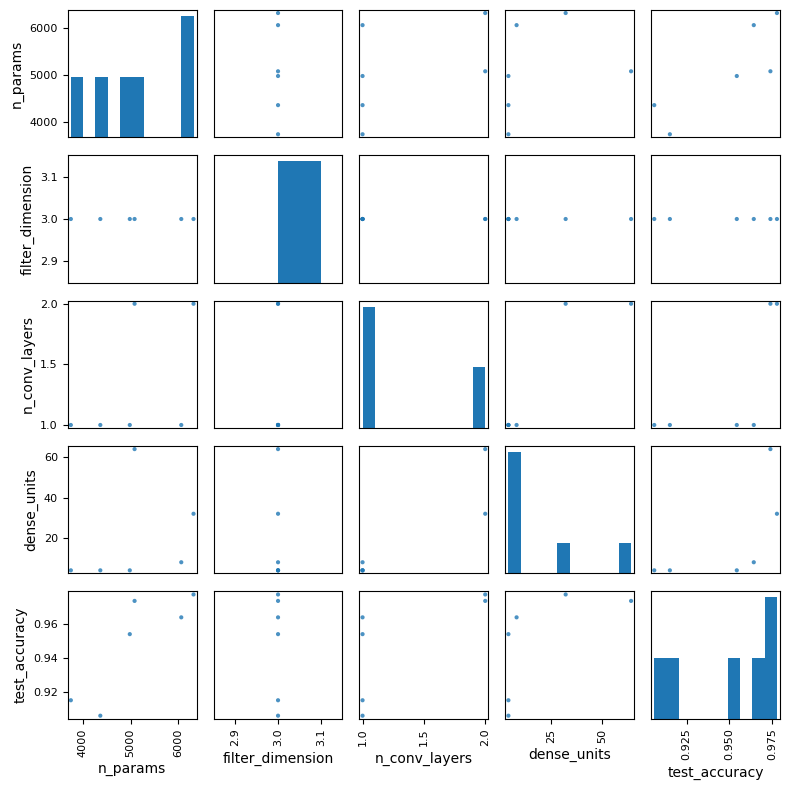

In [106]:
from pandas.plotting import scatter_matrix

filter_dimension_df = pd.DataFrame(filter_dimension_results)
scatter_matrix(filter_df[["n_params", "filter_dimension", "n_conv_layers", 
                          "dense_units", "test_accuracy"]], figsize=(8, 8), alpha=0.8)

# Show the plot
plt.tight_layout()
plt.show()

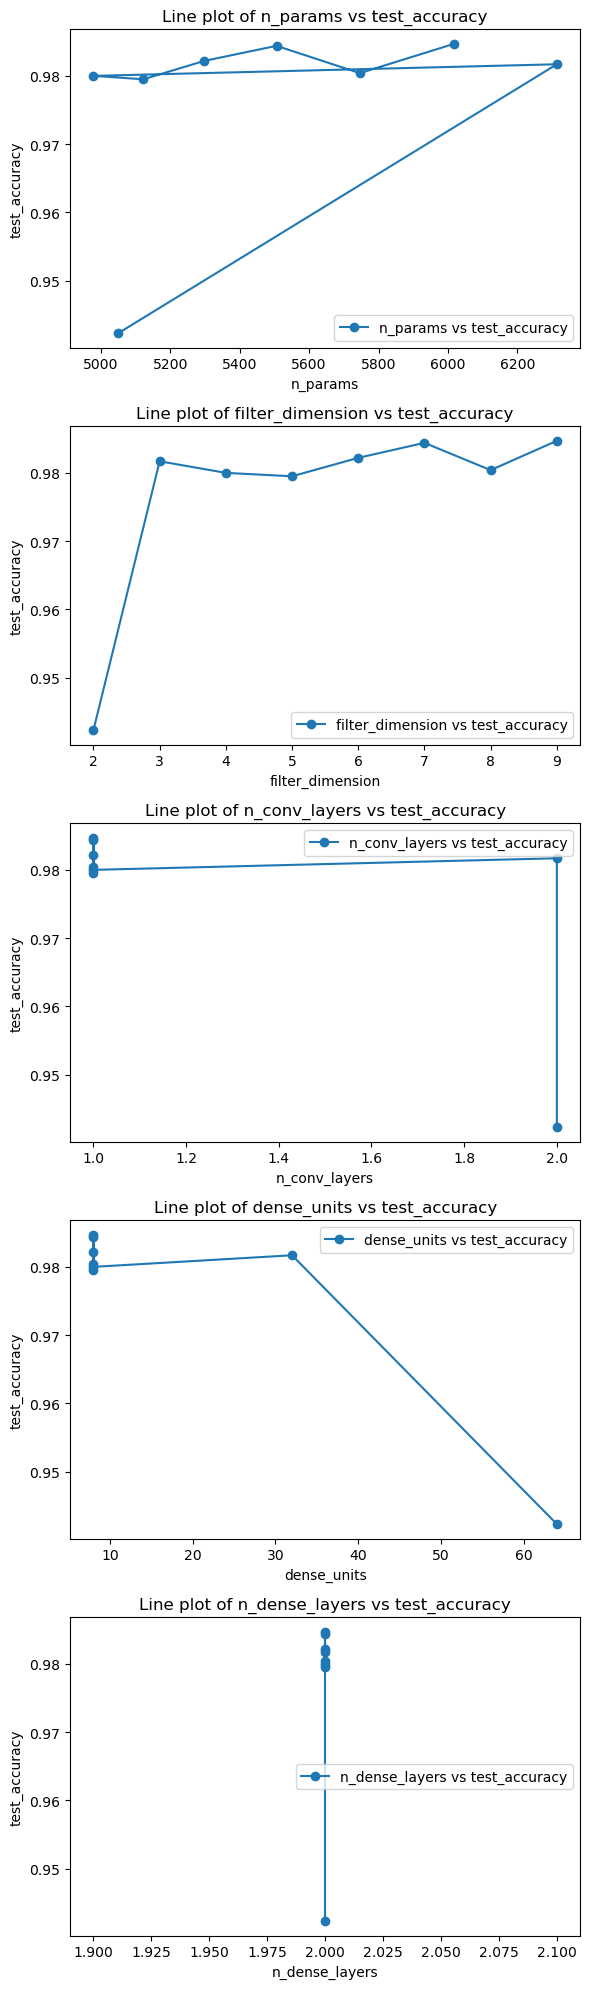

In [108]:
y_col = "test_accuracy"

ind_var_list = ["n_params", "filter_dimension", "n_conv_layers", "dense_units", "n_dense_layers"]

fig, axes = plt.subplots(len(ind_var_list), figsize=(6, 4 * (len(ind_var_list))))

for i, x_col in enumerate(ind_var_list):
    if x_col != y_col:
        ax = axes[i]
        ax.plot(filter_dimension_df[x_col], filter_dimension_df[y_col], marker="o", label=f"{x_col} vs {y_col}")
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(f"Line plot of {x_col} vs {y_col}")
        ax.legend()

plt.tight_layout()
plt.show()

## Iterating over the Number Of Dense Units

number of dense_units:  16
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  16
NEW TOTAL PARAMS:  5456.0
Model created with 5626.0 parameters.
**************************************************
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 26, 26, 16)        160       
                                               

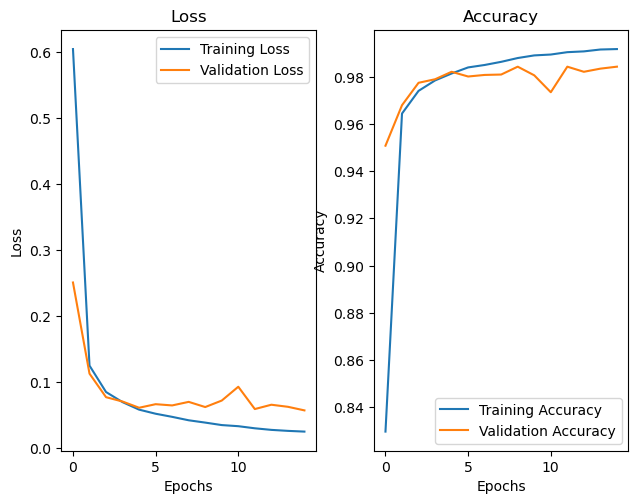

number of dense_units:  32
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  32
NEW TOTAL PARAMS:  5984.0
Model created with 6314.0 parameters.
**************************************************
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 26, 26, 16)        160       
                                               

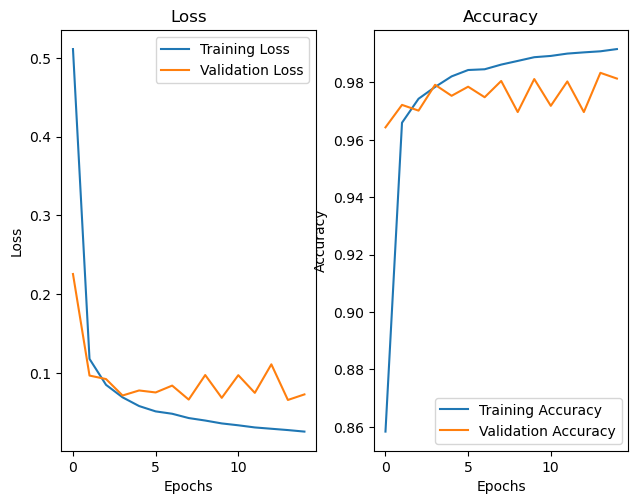

number of dense_units:  48
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  24.0
NEW TOTAL PARAMS:  5720.0
Model created with 5970.0 parameters.
**************************************************
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 26, 26, 16)        160       
                                             

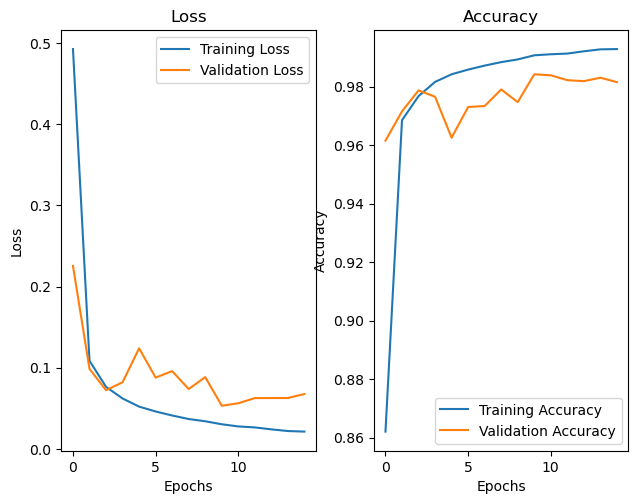

number of dense_units:  64
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  32.0
NEW TOTAL PARAMS:  5984.0
Model created with 6314.0 parameters.
**************************************************
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 26, 26, 16)        160       
                                             

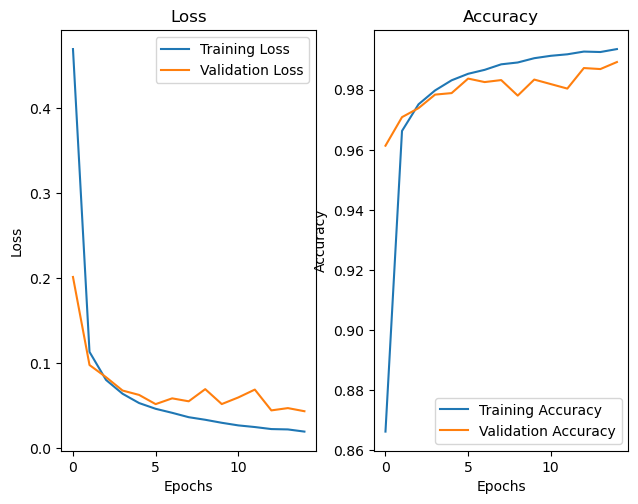

number of dense_units:  80
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  40.0
NEW TOTAL PARAMS:  6248.0
Model created with 6658.0 parameters.
**************************************************
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 26, 26, 16)        160       
                                             

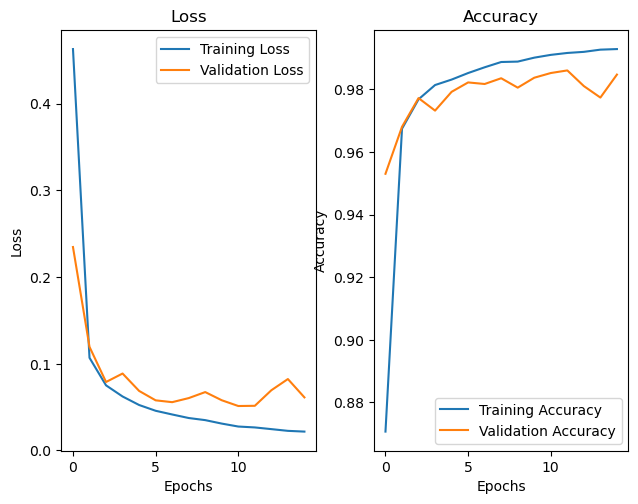

number of dense_units:  96
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  24.0
NEW TOTAL PARAMS:  5720.0
Model created with 5970.0 parameters.
**************************************************
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 26, 26, 16)        160       
                                             

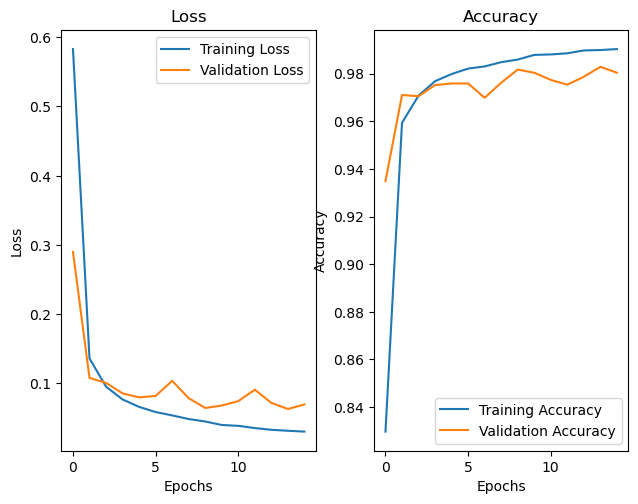

number of dense_units:  112
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  28.0
NEW TOTAL PARAMS:  5852.0
Model created with 6142.0 parameters.
**************************************************
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 26, 26, 16)        160       
                                            

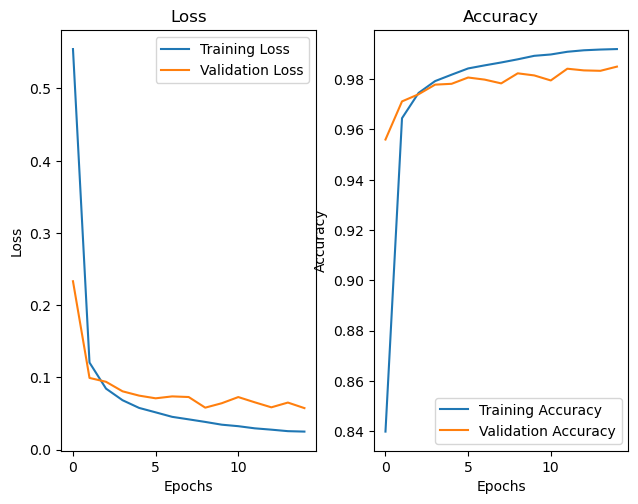

number of dense_units:  128
Building Model with:
input_shape:  (28, 28, 1)
num_classes:  10
max_params:  7000
current_shape:  (28, 28, 1)
current_shape:  (26, 26, 16)
Params count of the first conv input layer:  160
current_shape:  (6, 6, 16)
conv_params:  4640.0
batch_normalization_params:  128
delta_params_count:  4768.0
Adding layer:  2
NEW TOTAL PARAMS:  4928.0
current_shape:  (4, 4, 32)
current_shape:  (1, 1, 32)
conv_params:  18496.0
batch_normalization_params:  256
delta_params_count:  18752.0
Number of conv_layers:  2
Number of params related to conv layers:  4928.0
Flattened size:  32
dense_units:  32.0
NEW TOTAL PARAMS:  5984.0
Model created with 6314.0 parameters.
**************************************************
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 26, 26, 16)        160       
                                            

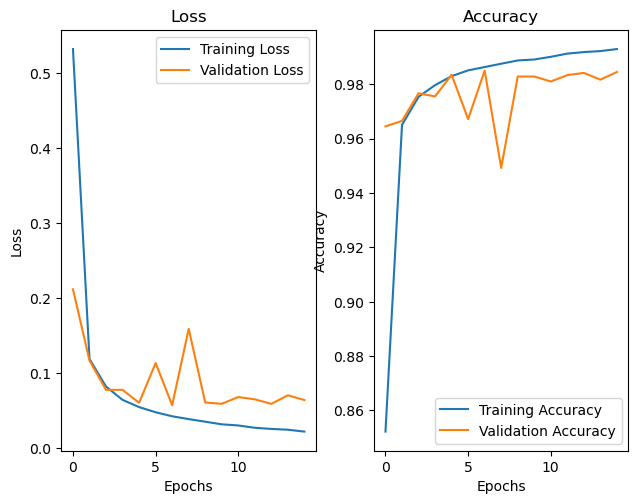

In [16]:



dense_units_results = {
    
    "n_params": [],
    "n_filters": [],
    "n_conv_layers": [],
    "n_dense_layers": [],
    "dense_units": [],
    "filter_dimension": [],
    "max_pooling_dimension": [],
    "test_accuracy": []
    
}

for dense_units in range(16, 136, 16):
    print("number of dense_units: ", dense_units)
    # Get input shape
    input_shape = x_train.shape[1:]
    
    try:
        # Build and compile the CNN
        model, n_params, n_filters, n_conv_layers,\
            n_dense_layers, dense_units, filter_dimension,\
            max_pooling_dimension = build_cnn(input_shape=input_shape, num_classes=num_classes, 
                                              dense_units=dense_units)
        
        model.summary()

        model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

        # Train the model
        history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

        # Evaluate the model
        test_loss, test_acc = model.evaluate(x_test, y_test)
        print(f"Test Accuracy: {test_acc}")

        plot_performance(history)
        
        dense_units_results["n_params"].append(n_params)
        dense_units_results["n_filters"].append(n_filters)
        dense_units_results["n_conv_layers"].append(n_conv_layers)
        dense_units_results["n_dense_layers"].append(n_dense_layers)
        dense_units_results["dense_units"].append(dense_units)
        dense_units_results["filter_dimension"].append(filter_dimension)
        dense_units_results["max_pooling_dimension"].append(max_pooling_dimension)
        dense_units_results["test_accuracy"].append(test_acc)
        
    except Exception as e:
        print(f"Failed creation of CNN with {dense_units} dense_units")
        print(str(e))
        


C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:102: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\s.crispino\AppData\Local\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:92: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


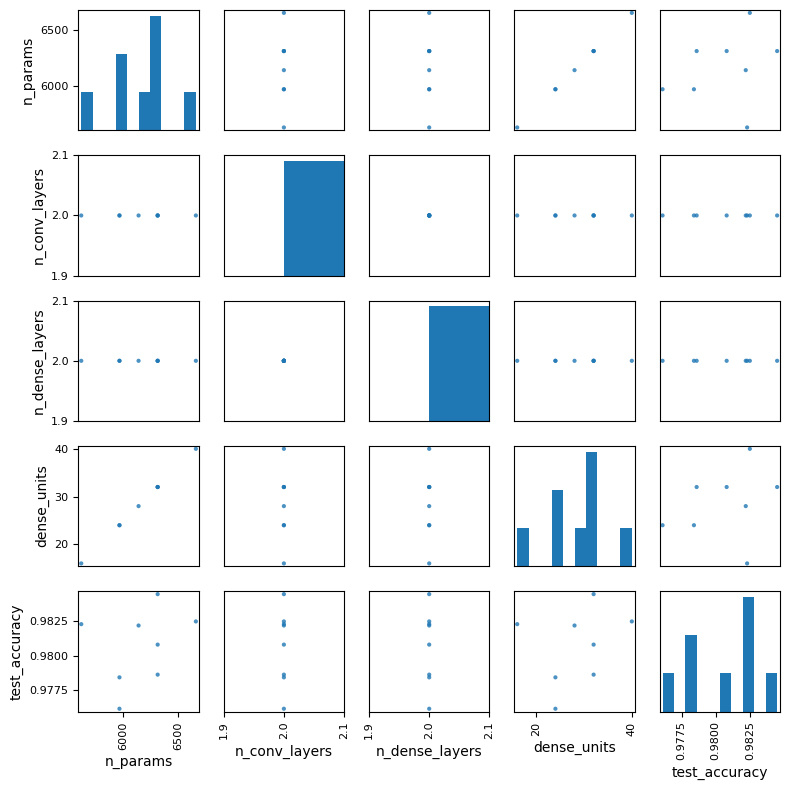

In [17]:
from pandas.plotting import scatter_matrix

dense_units_df = pd.DataFrame(dense_units_results)
scatter_matrix(dense_units_df[["n_params", "n_conv_layers", "n_dense_layers",
                          "dense_units", "test_accuracy"]], figsize=(8, 8), alpha=0.8)

# Show the plot
plt.tight_layout()
plt.show()

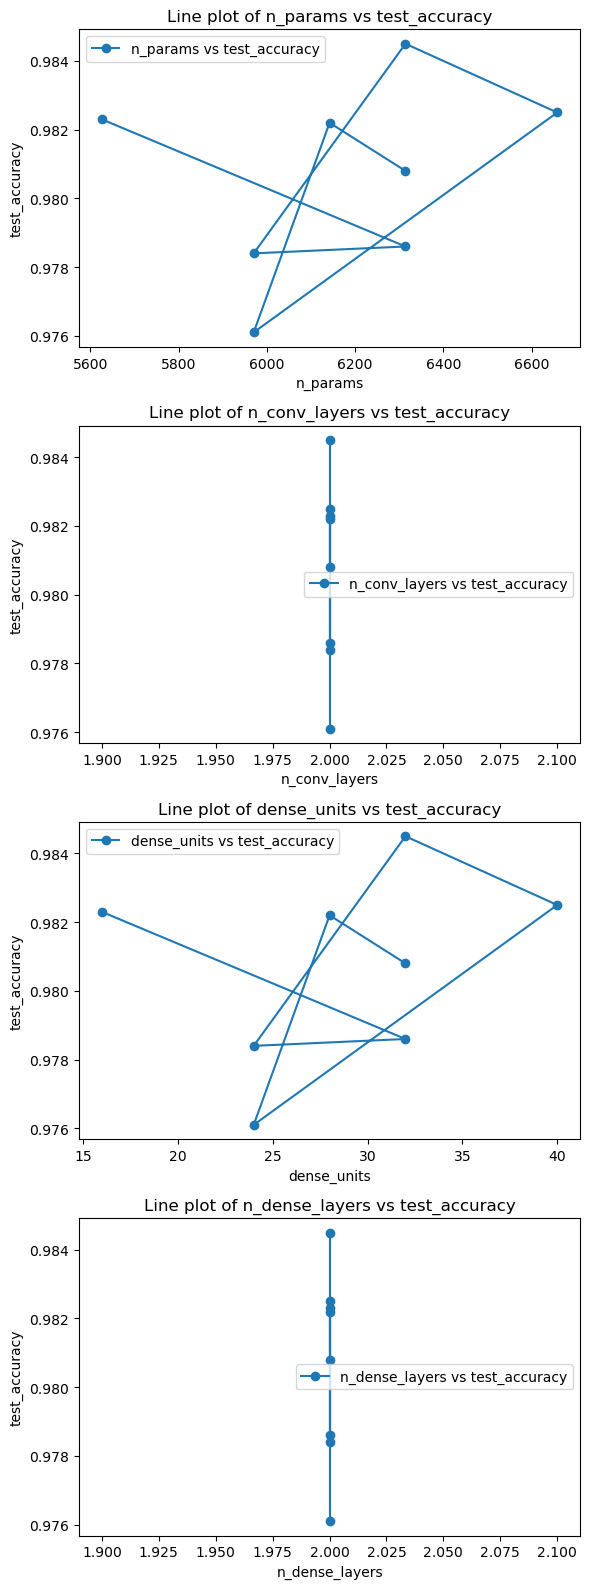

In [19]:
y_col = "test_accuracy"

ind_var_list = ["n_params", "n_conv_layers", "dense_units", "n_dense_layers"]

fig, axes = plt.subplots(len(ind_var_list), figsize=(6, 4 * (len(ind_var_list))))

for i, x_col in enumerate(ind_var_list):
    if x_col != y_col:
        ax = axes[i]
        ax.plot(dense_units_df[x_col], dense_units_df[y_col], marker="o", label=f"{x_col} vs {y_col}")
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(f"Line plot of {x_col} vs {y_col}")
        ax.legend()

plt.tight_layout()
plt.show()



## Results and interpretation

 - The accuracy score variance hasn't been very huge (max accuracy 0.98, min accuracy 0.91 across the experiments)
	- This could be interpreted as the fact that the high level CNN architectural choices (described in the first part) fit pretty well the small dataset of Mnist.
 - Both Training and validation accuracy follow the same tren with small differecens
     - This means that the model generalize enough and is able to campture the main patterns needed to properly classify instances of unseen data
	
 - For the major number of experiments the number of parameters used wasn't directly proportional to the test accuracy
 - The number of filter is proportionally inversed respect to the number of convolutional layers and dense units:
	- As explain before, under the parameters number constraint,  too much filters leads to less conv layers and dense units
	- Best test accuracy score have been achieved with a low number of filters (16) and the max possible number of convolutional layers (2)
		- This suggests that exists a thresold between the number of possible patterns and the hierarchical organization of patterns extracted.
 - The filter dimension doesn't seem to affect the overall test accuracy if the dimension is at least 3, filter dimension of 2 has been 
associated to the worst accuracy score.
 - The number of dense units negatively impacts the accuracy when it is less than 10 units, 
 so when it is less than the number of classes of the next output layer
	- this can be interpreted as a too high level of compression of the informations in respect of the classifier output layer.

# Trying other Architectures

In the previous set of experiments i've tried to study the effects of varying some specific factors on the test accuracy in a predefined type of CNN Architecture that was more focus on convolutional layers than fully-connected layers.
In other words, the experiments above worked on number and size of the filters, number of dense units but keeping almost the overall proportion between convolutional and dense layers: at least 2 convolutional layers and max 1 deep fully-connected layer.

In the next part of this notebook i tried to exasperate two different approach (keeping in count the max number of parameters limitation):

    1. Three convolutional layers CNN (with doubling of filters number as described above)
    2. Three deep fully-connected layers CNN (and only 1 convolutional layer)
    
This in order to compare a CNN focused on convolutional layers versus an Architecture based on deep dense layers.
The other factors (number and size of the filters, number of dense units, ...) have been adjusted in order to meet the 7000 parameters cap requirement. At this purpose, it's in fact important to know that the number of layers of the CNN, in the context of a parameters constraint, is directly affected by the shape of the input of each layer (that can't be zero o negative) that is in turn affected by factors like pooling matrix dimension, filter size, filter numbers, and so on. For this reason, in order to create CNN with the specific type and number of layers described above i have applied a more static and pragmatic strategy (no build_cnn method) in order to better control variables that could affect the layers type proportion.

In [ ]:
# Some functions to compute the number of params related to a specific layers

def compute_conv_params(filter_dimension, n_channels):
    return (filter_dimension * filter_dimension * n_channels + 1) * n_channels

def compute_batch_norm_params(n_channels):
    return n_channels*4

def compute_fc_params(input_channel, dense_units):
    reutn (input_channel + 1)* dense_units
    
def compute_output_params(input_channel, num_classes):
    reutn (input_channel + 1)* num_classes
    


## Architecture 1: Three convolutional layers CNN (code below)

In [39]:

max_params = 7000
input_shape = x_train.shape[1:]

model = models.Sequential()
params_count = 0
current_shape = input_shape

filters = 4
filter_dimension = 3

print("Layer 1")

model.add(layers.Conv2D(filters, (filter_dimension, filter_dimension), activation='relu', input_shape=input_shape))
params_count += (filter_dimension * filter_dimension * input_shape[-1] + 1) * filters  
current_shape = (current_shape[0] - (filter_dimension-1), current_shape[1] - (filter_dimension-1), filters)
print(f"shape after first conv layer: ", current_shape)
print(f"Params count of conv layer: ", params_count)


pooling_dimension = 2

# Add a pooling layer
model.add(layers.MaxPooling2D((pooling_dimension, pooling_dimension)))
current_shape = (current_shape[0] // pooling_dimension, current_shape[1] // pooling_dimension, current_shape[2])
print("current_shape after MaxPooling2D: ", current_shape)
print(f"Params count of MaxPooling2D : ", params_count)

##################################### SECOND CONV LAYER ##############################
print("Layer 2")
filters *= 2

pooling_dimension = 2

conv_params = (filter_dimension * filter_dimension * filters/2) * filters + 1*filters
batch_normalization_params = 4 * filters

print("conv_params: ", conv_params)
print("batch_normalization_params: ", batch_normalization_params)
delta_params_count = (conv_params + batch_normalization_params)

params_count += delta_params_count
print("TOTAL PARAMS WILL BE: ", params_count)

current_shape = (current_shape[0] - (filter_dimension-1), current_shape[1] - (filter_dimension-1), filters)
print("current_shape after Conv2D will be: ", current_shape)
model.add(layers.Conv2D(filters, (filter_dimension, filter_dimension), activation='relu'))       

current_shape = (current_shape[0] // pooling_dimension, current_shape[1] // pooling_dimension, current_shape[2])
print("current_shape after MaxPooling2D will be: ", current_shape)
model.add(layers.MaxPooling2D((pooling_dimension, pooling_dimension)))


model.add(layers.BatchNormalization())
###################################### THIRD CONV LAYER ##################################### 
print("Layer 3")
filters *= 2

pooling_dimension = 2

conv_params = (filter_dimension * filter_dimension * filters/2) * filters + 1*filters
batch_normalization_params = 4 * filters

print("conv_params: ", conv_params)
print("batch_normalization_params: ", batch_normalization_params)
delta_params_count = (conv_params + batch_normalization_params)

params_count += delta_params_count
print("TOTAL PARAMS WILL BE: ", params_count)


current_shape = (current_shape[0] - (filter_dimension-1), current_shape[1] - (filter_dimension-1), filters)
print("current_shape after Conv2D will be: ", current_shape)
model.add(layers.Conv2D(filters, (filter_dimension, filter_dimension), activation='relu'))       

current_shape = (current_shape[0] // pooling_dimension, current_shape[1] // pooling_dimension, current_shape[2])
print("current_shape after MaxPooling2D will be: ", current_shape)
model.add(layers.MaxPooling2D((pooling_dimension, pooling_dimension)))

model.add(layers.BatchNormalization())



############################# FULLY-CONNECT PART ################################à

 # Calculate the flattened size
flattened_size = np.prod(current_shape)
print("Flattened size: ", flattened_size)

dense_units = 128

while flattened_size * dense_units + dense_units + num_classes*dense_units + num_classes > max_params - params_count:
    dense_units = dense_units / 2

print("dense_units: ", dense_units)
# Flatten and add a dense layer for classification
model.add(layers.Flatten())

n_dense_layers = 0


if dense_units > num_classes:
    model.add(layers.Dense(dense_units, activation='relu'))
    params_count += (flattened_size * dense_units + dense_units)
    print("NEW TOTAL PARAMS: ", params_count)

# Add the output layer
model.add(layers.Dense(num_classes, activation='softmax'))
params_count += (dense_units + 1) * num_classes


print(f"Model created with {params_count} parameters.")
print("*"*50)

model.summary()

Layer 1
shape after first conv layer:  (26, 26, 4)
Params count of conv layer:  40
current_shape after MaxPooling2D:  (13, 13, 4)
Params count of MaxPooling2D :  40
Layer 2
conv_params:  296.0
batch_normalization_params:  32
TOTAL PARAMS WILL BE:  368.0
current_shape after Conv2D will be:  (11, 11, 8)
current_shape after MaxPooling2D will be:  (5, 5, 8)
Layer 3
conv_params:  1168.0
batch_normalization_params:  64
TOTAL PARAMS WILL BE:  1600.0
current_shape after Conv2D will be:  (3, 3, 16)
current_shape after MaxPooling2D will be:  (1, 1, 16)
Flattened size:  16
dense_units:  128
NEW TOTAL PARAMS:  3776.0
Model created with 5066.0 parameters.
**************************************************
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 26, 26, 4)         40        
                                                                 
 max_poolin

## Architecture 1: Three convolutional layers CNN - Results and other considerations 

In this case we can highlight two main observations. 

The first one is the fact that the overall accuracy against the test dataset is average in respect of the experiments of the previous part of the notebook. So it seems that increasing the number of convolutional layer without fine-tuning the other factors (filter size, ...) does not have a huge impact on the model performance. In this regard it's also fair to report that in order to allow under constraint this number of layers i had to set the base number of filters to 8 that could not be the optimal for the classification task against mnist dataset (as described in the previous part, best filter numbers found during the experiments was 16).

The second one is about the fact, as it's possible to verify looking at the performance plot, that accuracy trends in training and validation largely diverge in the last epochs. This could be interpreted as the fact that the deeper convolutional layers tend to learn very specific patterns that don't actually help to generalize the calssifivation problem.

Epoch 1/15
422/422 [==============================] - 6s 10ms/step - loss: 0.0631 - accuracy: 0.9795 - val_loss: 0.0823 - val_accuracy: 0.9787
Epoch 2/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0621 - accuracy: 0.9799 - val_loss: 0.0756 - val_accuracy: 0.9798
Epoch 3/15
422/422 [==============================] - 3s 6ms/step - loss: 0.0587 - accuracy: 0.9810 - val_loss: 0.0794 - val_accuracy: 0.9793
Epoch 4/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0580 - accuracy: 0.9809 - val_loss: 0.0743 - val_accuracy: 0.9803
Epoch 5/15
422/422 [==============================] - 5s 11ms/step - loss: 0.0558 - accuracy: 0.9823 - val_loss: 0.0747 - val_accuracy: 0.9798
Epoch 6/15
422/422 [==============================] - 3s 7ms/step - loss: 0.0554 - accuracy: 0.9818 - val_loss: 0.0816 - val_accuracy: 0.9788
Epoch 7/15
422/422 [==============================] - 4s 10ms/step - loss: 0.0545 - accuracy: 0.9822 - val_loss: 0.0817 - val_accuracy: 0.9793
Epo

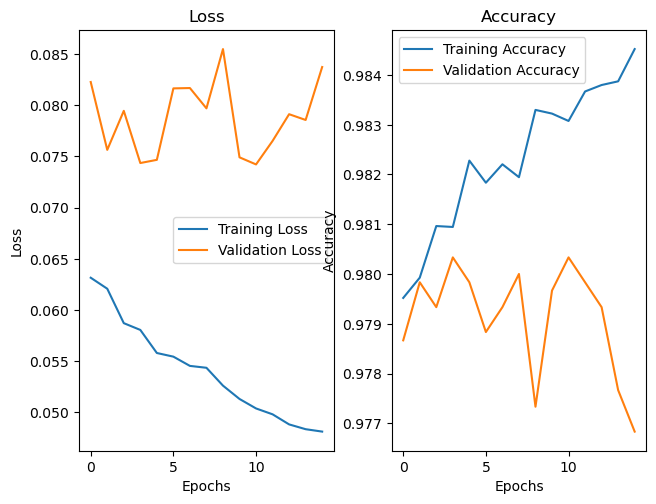

In [87]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

plot_performance(history)

## Architecture 2: Three deep fully-connected layers CNN (code below)

In [95]:
max_params = 7000
input_shape = x_train.shape[1:]

model = models.Sequential()
params_count = 0
current_shape = input_shape

filters = 8
filter_dimension = 4

print("Layer 1")

model.add(layers.Conv2D(filters, (filter_dimension, filter_dimension), activation='relu', input_shape=input_shape))
params_count += (filter_dimension * filter_dimension * input_shape[-1] + 1) * filters  
current_shape = (current_shape[0] - (filter_dimension-1), current_shape[1] - (filter_dimension-1), filters)
print(f"shape after first conv layer: ", current_shape)
print(f"Params count of conv layer: ", params_count)


pooling_dimension = 8

# Add a pooling layer
model.add(layers.MaxPooling2D((pooling_dimension, pooling_dimension)))
current_shape = (current_shape[0] // pooling_dimension, current_shape[1] // pooling_dimension, current_shape[2])
print("current_shape after MaxPooling2D: ", current_shape)
print(f"Params count of MaxPooling2D : ", params_count)

model.add(layers.BatchNormalization())

############################# FULLY-CONNECT PART 1 ################################à

 # Calculate the flattened size
flattened_size = np.prod(current_shape)
print("Flattened size: ", flattened_size)

dense_units = 128

while flattened_size * dense_units + dense_units + num_classes*dense_units + num_classes > max_params - params_count:
    dense_units = dense_units / 2

print("dense_units: ", dense_units)
# Flatten and add a dense layer for classification
model.add(layers.Flatten())

n_dense_layers = 0


if dense_units > num_classes:
    print("fc 1")
    model.add(layers.Dense(dense_units, activation='relu'))
    params_count += (flattened_size * dense_units + dense_units)
    print("NEW TOTAL PARAMS: ", params_count)


############################# FULLY-CONNECT PART 2 ################################

dense_units_2 = 128

while dense_units * dense_units_2 + dense_units_2 + num_classes*dense_units_2 + num_classes > max_params - params_count:
    dense_units_2 = dense_units_2 / 2

print("dense_units: ", dense_units_2)

if dense_units_2 > num_classes:
    print("fc 2")
    model.add(layers.Dense(dense_units_2, activation='relu'))
    params_count += (dense_units * dense_units_2 + dense_units_2)
    print("NEW TOTAL PARAMS: ", params_count)
    
    
############################# FULLY-CONNECT PART 3 ################################à

dense_units_3 = 128

while dense_units_2 * dense_units_3 + dense_units_3 + num_classes*dense_units_3 + num_classes > max_params - params_count:
    dense_units_3 = dense_units_3 / 2

print("dense_units: ", dense_units_3)

if dense_units_3 > num_classes:
    print("fc 3")
    model.add(layers.Dense(dense_units_3, activation='relu'))
    params_count += (dense_units_2 * dense_units_3 + dense_units_3)
    print("NEW TOTAL PARAMS: ", params_count)

################################################# OUTPUT LAYER ################################################
# Add the output layer
model.add(layers.Dense(num_classes, activation='softmax'))
params_count += (dense_units_3 + 1) * num_classes


print(f"Model created with {params_count} parameters.")
print("*"*50)

model.summary()

Layer 1
shape after first conv layer:  (25, 25, 8)
Params count of conv layer:  136
current_shape after MaxPooling2D:  (3, 3, 8)
Params count of MaxPooling2D :  136
Flattened size:  72
dense_units:  64.0
fc 1
NEW TOTAL PARAMS:  4808.0
dense_units:  16.0
fc 2
NEW TOTAL PARAMS:  5848.0
dense_units:  32.0
fc 3
NEW TOTAL PARAMS:  6392.0
Model created with 6722.0 parameters.
**************************************************
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 25, 25, 8)         136       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 3, 3, 8)           0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 3, 3, 8)           32        
 tchNormalization)       

## Architecture 2: Three deep fully-connected layers CNN - Results and further considerations

Also in this case we can agree that the model's performace is average, although slightly better than the previous architecture.
An important detail that we can observe in this second training phase is the fact that accuracy against training and validation test is very similar and follow the same trend across all the epochs, suggesting that this second architecture is less prone to overfitting.
So we can interpret this result as the ability of a single convolutional layer to properly capture the main spatial patterns needed to recognize the digits within a small dataset like Mnist. This features are succesively passed to the fully-connected layers which are able to aggregate them in order to combine e prioritize them and succesfully achieve a good result accuracy.



Epoch 1/15
422/422 [==============================] - 5s 9ms/step - loss: 0.5494 - accuracy: 0.8307 - val_loss: 0.1712 - val_accuracy: 0.9520
Epoch 2/15
422/422 [==============================] - 4s 9ms/step - loss: 0.1444 - accuracy: 0.9540 - val_loss: 0.1146 - val_accuracy: 0.9623
Epoch 3/15
422/422 [==============================] - 3s 8ms/step - loss: 0.1114 - accuracy: 0.9644 - val_loss: 0.0901 - val_accuracy: 0.9718
Epoch 4/15
422/422 [==============================] - 3s 6ms/step - loss: 0.0964 - accuracy: 0.9691 - val_loss: 0.0795 - val_accuracy: 0.9740
Epoch 5/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0853 - accuracy: 0.9728 - val_loss: 0.0754 - val_accuracy: 0.9768
Epoch 6/15
422/422 [==============================] - 3s 7ms/step - loss: 0.0770 - accuracy: 0.9754 - val_loss: 0.0705 - val_accuracy: 0.9787
Epoch 7/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0720 - accuracy: 0.9767 - val_loss: 0.0742 - val_accuracy: 0.9782
Epoch 

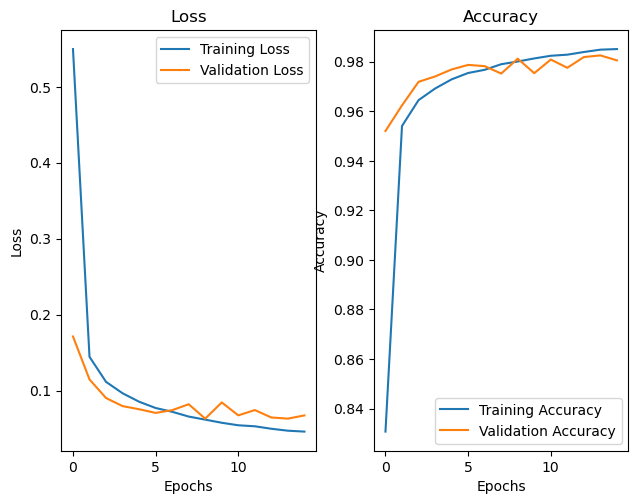

In [96]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

plot_performance(history)

## Do we really need more deep layers? 

In order to answer to this question i performed a few of other tests reducing the CNN architecture to the bone: only 1 convolutional layer (followed by max pooling and batch normalization) and 1 dense layer and i still got a good result in the test accuracy (0.98).

Then i simplify the network even further i tried a deep network without convolutional layer and i got an accuracy score of 0.92. This decrease in the accuracy supports the fact that (at least) a convolutional layer really helps to discover useful spatial patterns and has a key role in spatial classification task. This hypothesis it's also confirmed by the fact that a CNN with only 1 convolutional layer but no deep dense layers has an accuracy score of 0.97 (see last experiment section: " More and More Even Simpler Architecture: Only 1 Convolutional Layer (no deep dense layers") 

Finally, i trained a simple NN with just one dense layer (further than the output layer) and i still got the same accuracy of the previous case (0.92).

So, considering that a 0.92 accuracy score it's still a good result in many cases and considering that also in the last experiments validationa and training scores follow the same trend, we can assume that Mnist it's enough small and simple  that can be properly learnt by very simple architecture without any particular hyperparameters fine-tuning. 

## Simpler Architecture: 1 Convolutional Layer + 1 Dense Layer

In [15]:
max_params = 7000
input_shape = x_train.shape[1:]

model = models.Sequential()
params_count = 0
current_shape = input_shape

filters = 16
filter_dimension = 4

print("Layer 1")

model.add(layers.Conv2D(filters, (filter_dimension, filter_dimension), activation='relu', input_shape=input_shape))
params_count += (filter_dimension * filter_dimension * input_shape[-1] + 1) * filters  
current_shape = (current_shape[0] - (filter_dimension-1), current_shape[1] - (filter_dimension-1), filters)
print(f"shape after first conv layer: ", current_shape)
print(f"Params count of conv layer: ", params_count)


pooling_dimension = 8

# Add a pooling layer
model.add(layers.MaxPooling2D((pooling_dimension, pooling_dimension)))
current_shape = (current_shape[0] // pooling_dimension, current_shape[1] // pooling_dimension, current_shape[2])
print("current_shape after MaxPooling2D: ", current_shape)
print(f"Params count of MaxPooling2D : ", params_count)

model.add(layers.BatchNormalization())
params_count += 4*current_shape[-1]
############################# FULLY-CONNECT PART 1 ################################à

 # Calculate the flattened size
flattened_size = np.prod(current_shape)
print("Flattened size: ", flattened_size)

dense_units = 128

while flattened_size * dense_units + dense_units + num_classes*dense_units + num_classes > max_params - params_count:
    dense_units = dense_units / 2

print("dense_units: ", dense_units)
# Flatten and add a dense layer for classification
model.add(layers.Flatten())

n_dense_layers = 0


if dense_units > num_classes:
    print("fc 1")
    model.add(layers.Dense(dense_units, activation='relu'))
    params_count += (flattened_size * dense_units + dense_units)
    print("NEW TOTAL PARAMS: ", params_count)




################################################# OUTPUT LAYER ################################################
# Add the output layer
model.add(layers.Dense(num_classes, activation='softmax'))
params_count += (dense_units + 1) * num_classes


print(f"Model created with {params_count} parameters.")
print("*"*50)

model.summary()

Layer 1
shape after first conv layer:  (25, 25, 16)
Params count of conv layer:  272
current_shape after MaxPooling2D:  (3, 3, 16)
Params count of MaxPooling2D :  272
Flattened size:  144
dense_units:  32.0
fc 1
NEW TOTAL PARAMS:  4976.0
Model created with 5306.0 parameters.
**************************************************
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 16)          0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 3, 3, 16)          64        
 chNormalization)                                                
                                                         

Epoch 1/15
422/422 [==============================] - 3s 6ms/step - loss: 0.4218 - accuracy: 0.8759 - val_loss: 0.1596 - val_accuracy: 0.9675
Epoch 2/15
422/422 [==============================] - 2s 6ms/step - loss: 0.1133 - accuracy: 0.9641 - val_loss: 0.0824 - val_accuracy: 0.9745
Epoch 3/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0853 - accuracy: 0.9728 - val_loss: 0.0669 - val_accuracy: 0.9788
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0729 - accuracy: 0.9773 - val_loss: 0.0677 - val_accuracy: 0.9800
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0654 - accuracy: 0.9799 - val_loss: 0.0577 - val_accuracy: 0.9810
Epoch 6/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0596 - accuracy: 0.9815 - val_loss: 0.0566 - val_accuracy: 0.9825
Epoch 7/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0562 - accuracy: 0.9815 - val_loss: 0.0537 - val_accuracy: 0.9832
Epoch 

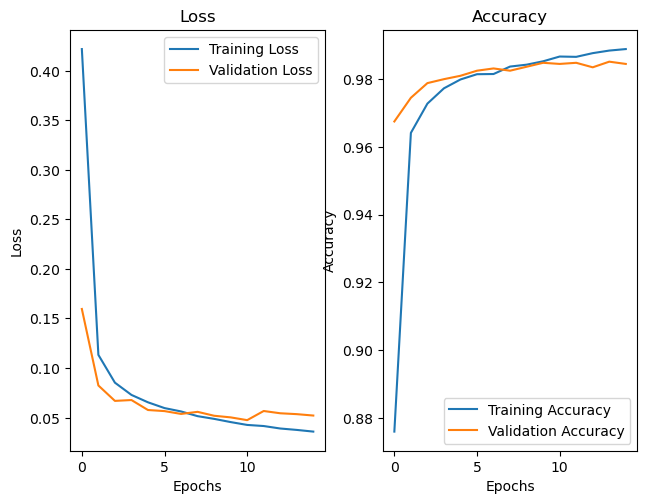

In [14]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

plot_performance(history)

## Even Simpler Architecture: Only Dense Layers (No convolutional Layers)

In [29]:
import numpy as np
from tensorflow.keras import models, layers

# Example input shape and number of classes
input_shape = (28, 28)  # Adjust based on your data
num_classes = 10
max_params = 7000

# Initialize the Sequential model
model = models.Sequential()

# Set input shape explicitly for the first layer
flattened_size = np.prod(input_shape)
model.add(layers.Flatten(input_shape=input_shape))

# Track parameter count
params_count = 0
current_shape = flattened_size

# Define initial dense units
dense_units = 128

stop = False
while not stop:
    stop = dense_units < num_classes

    # Check if the next Dense layer fits within the parameter limit
    layer_params = current_shape * dense_units + dense_units
    if params_count + layer_params + (dense_units + 1) * num_classes <= max_params:
        model.add(layers.Dense(dense_units, activation='relu'))
        params_count += layer_params
        current_shape = dense_units  # Update current shape
    else:
        dense_units //= 2  # Reduce layer size if it exceeds parameter budget

# Add the output layer
model.add(layers.Dense(num_classes, activation='softmax'))
params_count += (current_shape + 1) * num_classes

# Print results
print(f"Model created with {params_count} parameters.")
print("*" * 50)

model.summary()


Model created with 6370 parameters.
**************************************************
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 8)                 6280      
                                                                 
 dense_18 (Dense)            (None, 10)                90        
                                                                 
Total params: 6370 (24.88 KB)
Trainable params: 6370 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/15
422/422 [==============================] - 1s 2ms/step - loss: 0.9636 - accuracy: 0.7192 - val_loss: 0.3659 - val_accuracy: 0.9067
Epoch 2/15
422/422 [==============================] - 1s 2ms/step - loss: 0.3872 - accuracy: 0.8916 - val_loss: 0.2876 - val_accuracy: 0.9235
Epoch 3/15
422/422 [==============================] - 1s 2ms/step - loss: 0.3373 - accuracy: 0.9047 - val_loss: 0.2650 - val_accuracy: 0.9277
Epoch 4/15
422/422 [==============================] - 1s 2ms/step - loss: 0.3169 - accuracy: 0.9109 - val_loss: 0.2565 - val_accuracy: 0.9283
Epoch 5/15
422/422 [==============================] - 1s 2ms/step - loss: 0.3048 - accuracy: 0.9149 - val_loss: 0.2475 - val_accuracy: 0.9313
Epoch 6/15
422/422 [==============================] - 1s 2ms/step - loss: 0.2968 - accuracy: 0.9169 - val_loss: 0.2465 - val_accuracy: 0.9312
Epoch 7/15
422/422 [==============================] - 1s 2ms/step - loss: 0.2904 - accuracy: 0.9189 - val_loss: 0.2419 - val_accuracy: 0.9318
Epoch 

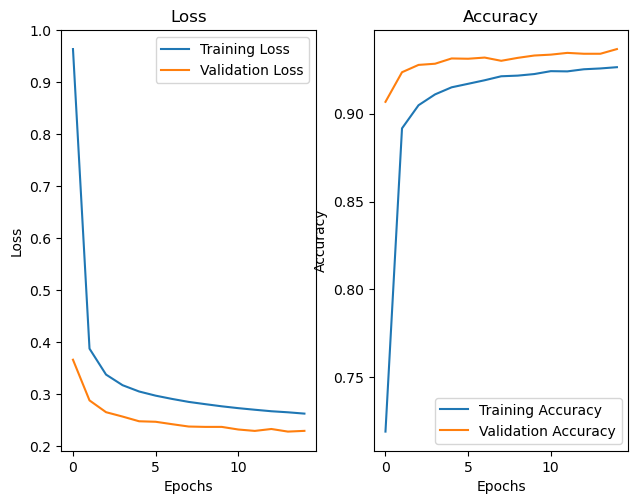

In [30]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

plot_performance(history)

## More Even Simpler Architecture: Only 1 Dense Layers 

In [31]:
import numpy as np
from tensorflow.keras import models, layers

# Example input shape and number of classes
input_shape = (28, 28)  # Adjust based on your data
num_classes = 10
max_params = 7000

# Initialize the Sequential model
model = models.Sequential()

# Set input shape explicitly for the first layer
flattened_size = np.prod(input_shape)
model.add(layers.Flatten(input_shape=input_shape))

# Track parameter count
params_count = 0
current_shape = flattened_size

# Define initial dense units
dense_units = 128

stop = False
while not stop:
    stop = dense_units < num_classes

    # Check if the next Dense layer fits within the parameter limit
    layer_params = current_shape * dense_units + dense_units
    if params_count + layer_params + (dense_units + 1) * num_classes <= max_params:
        model.add(layers.Dense(dense_units, activation='relu'))
        params_count += layer_params
        current_shape = dense_units  # Update current shape
        stop = True
    else:
        dense_units //= 2  # Reduce layer size if it exceeds parameter budget

# Add the output layer
model.add(layers.Dense(num_classes, activation='softmax'))
params_count += (current_shape + 1) * num_classes

# Print results
print(f"Model created with {params_count} parameters.")
print("*" * 50)

model.summary()


Model created with 6370 parameters.
**************************************************
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 8)                 6280      
                                                                 
 dense_20 (Dense)            (None, 10)                90        
                                                                 
Total params: 6370 (24.88 KB)
Trainable params: 6370 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/15
422/422 [==============================] - 1s 2ms/step - loss: 0.8673 - accuracy: 0.7483 - val_loss: 0.4041 - val_accuracy: 0.8915
Epoch 2/15
422/422 [==============================] - 1s 2ms/step - loss: 0.4085 - accuracy: 0.8850 - val_loss: 0.3072 - val_accuracy: 0.9162
Epoch 3/15
422/422 [==============================] - 1s 2ms/step - loss: 0.3462 - accuracy: 0.9016 - val_loss: 0.2777 - val_accuracy: 0.9215
Epoch 4/15
422/422 [==============================] - 1s 2ms/step - loss: 0.3199 - accuracy: 0.9085 - val_loss: 0.2625 - val_accuracy: 0.9260
Epoch 5/15
422/422 [==============================] - 1s 2ms/step - loss: 0.3040 - accuracy: 0.9127 - val_loss: 0.2529 - val_accuracy: 0.9292
Epoch 6/15
422/422 [==============================] - 1s 2ms/step - loss: 0.2932 - accuracy: 0.9163 - val_loss: 0.2499 - val_accuracy: 0.9308
Epoch 7/15
422/422 [==============================] - 1s 2ms/step - loss: 0.2851 - accuracy: 0.9189 - val_loss: 0.2416 - val_accuracy: 0.9317
Epoch 

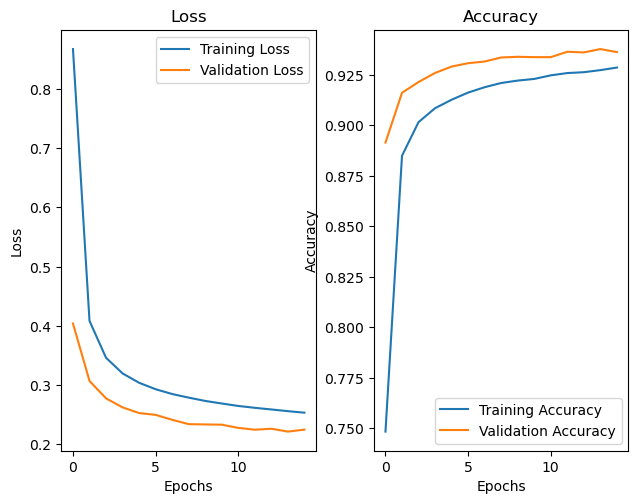

In [32]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

plot_performance(history)

## More and More Even Simpler Architecture: Only 1 Convolutional Layer (no deep dense layers)

In [33]:
max_params = 7000
input_shape = x_train.shape[1:]

model = models.Sequential()
params_count = 0
current_shape = input_shape

filters = 16
filter_dimension = 4

print("Layer 1")

model.add(layers.Conv2D(filters, (filter_dimension, filter_dimension), activation='relu', input_shape=input_shape))
params_count += (filter_dimension * filter_dimension * input_shape[-1] + 1) * filters  
current_shape = (current_shape[0] - (filter_dimension-1), current_shape[1] - (filter_dimension-1), filters)
print(f"shape after first conv layer: ", current_shape)
print(f"Params count of conv layer: ", params_count)


pooling_dimension = 8

# Add a pooling layer
model.add(layers.MaxPooling2D((pooling_dimension, pooling_dimension)))
current_shape = (current_shape[0] // pooling_dimension, current_shape[1] // pooling_dimension, current_shape[2])
print("current_shape after MaxPooling2D: ", current_shape)
print(f"Params count of MaxPooling2D : ", params_count)

model.add(layers.BatchNormalization())
params_count += 4*current_shape[-1]
############################# FULLY-CONNECT PART 1 ################################à

 # Calculate the flattened size
flattened_size = np.prod(current_shape)
print("Flattened size: ", flattened_size)


print("dense_units: ", dense_units)
# Flatten and add a dense layer for classification
model.add(layers.Flatten())





################################################# OUTPUT LAYER ################################################
# Add the output layer
model.add(layers.Dense(num_classes, activation='softmax'))
params_count += (flattened_size + 1) * num_classes


print(f"Model created with {params_count} parameters.")
print("*"*50)

model.summary()

Layer 1
shape after first conv layer:  (25, 25, 16)
Params count of conv layer:  272
current_shape after MaxPooling2D:  (3, 3, 16)
Params count of MaxPooling2D :  272
Flattened size:  144
dense_units:  8
Model created with 1786 parameters.
**************************************************
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 16)          0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 3, 3, 16)          64        
 chNormalization)                                                
                                                                 
 flatten_12 (Flatten)     

Epoch 1/15
422/422 [==============================] - 3s 6ms/step - loss: 0.5975 - accuracy: 0.8304 - val_loss: 0.3049 - val_accuracy: 0.9445
Epoch 2/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1742 - accuracy: 0.9513 - val_loss: 0.1220 - val_accuracy: 0.9627
Epoch 3/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1207 - accuracy: 0.9645 - val_loss: 0.0984 - val_accuracy: 0.9697
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0993 - accuracy: 0.9703 - val_loss: 0.0804 - val_accuracy: 0.9743
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0871 - accuracy: 0.9738 - val_loss: 0.0760 - val_accuracy: 0.9758
Epoch 6/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0799 - accuracy: 0.9758 - val_loss: 0.0773 - val_accuracy: 0.9762
Epoch 7/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0748 - accuracy: 0.9769 - val_loss: 0.0787 - val_accuracy: 0.9760
Epoch 

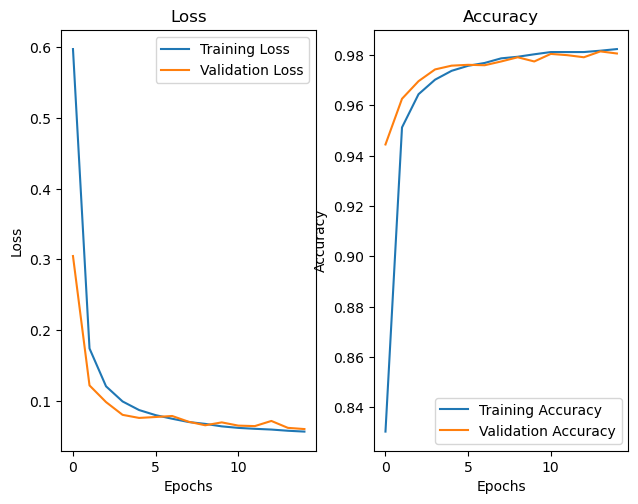

In [34]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

plot_performance(history)